In [174]:
import sys
print(sys.version)
import tensorflow as tf

# Enable mixed precision
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

print('TensorFlow version: ',tf.__version__)
print(tf.sysconfig.get_build_info()['cuda_version'])
print(tf.sysconfig.get_build_info()['cudnn_version'])
#print("Available GPUs:", tf.config.list_physical_devices('GPU'))
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Conv2D, Flatten, GRU, Reshape, MaxPooling2D, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Nadam, Adam, Adagrad, Adadelta
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.losses import Huber
# Removed by keras
#from tensorflow.keras.optimizers.legacy import Adadelta, Nadam, Adagrad, Adam
from tensorflow.keras.utils import plot_model
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from IPython.display import Image
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, euclidean_distances
from sklearn.feature_selection import f_regression
import numpy as np
import random
from collections import deque

3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]
TensorFlow version:  2.17.0
12.3
8


In [3]:
# Check if TensorFlow is built with CUDA (GPU) support
print("Built with CUDA:", tf.test.is_built_with_cuda())

# List available GPUs
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

# List the physical GPUs that TensorFlow can access
print("TensorFlow Devices: ", tf.config.list_physical_devices())

# Set memory growth to prevent TensorFlow from consuming all the GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

if physical_devices:
    # Set log device placement to True to see device assignment
    #tf.debugging.set_log_device_placement(True)

    # Example TensorFlow computation to see if GPU is used
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)

    print(c)
else:
    print("No GPU detected.")

Built with CUDA: True
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
def DH(thi, di, ai, ali):
    thi = np.radians(thi)
    ali = np.radians(ali)
    T = np.array([
        [np.cos(thi), -np.sin(thi)*np.cos(ali), np.sin(thi)*np.sin(ali), ai*np.cos(thi)],
        [np.sin(thi), np.cos(thi)*np.cos(ali), -np.cos(thi)*np.sin(ali), ai*np.sin(thi)],
        [0, np.sin(ali), np.cos(ali), di],
        [0, 0, 0, 1]
    ])
    return T

In [5]:
def tfDH(theta, d, a, alpha):
    # Convert degrees to radians
    theta = tf.cast(theta, tf.float32)
    alpha = tf.cast(alpha, tf.float32)
    pi_on_180 = tf.constant(np.pi / 180, dtype=tf.float32)
    theta = theta * pi_on_180
    alpha = tf.fill(tf.shape(theta), tf.cast(alpha, dtype=tf.float32)) * pi_on_180

    c_theta = tf.cos(theta)
    s_theta = tf.sin(theta)
    c_alpha = tf.cos(alpha)
    s_alpha = tf.sin(alpha)

    zero = tf.zeros_like(c_theta)
    one = tf.ones_like(c_theta)

    a = tf.fill(tf.shape(theta), a)
    d = tf.fill(tf.shape(theta), d)

    print("theta shape:", tf.shape(theta))
    print("alpha shape:", tf.shape(alpha))
    print("a shape:", tf.shape(a))
    print("d shape:", tf.shape(d))
    
    
    # Ensure a and d are treated as float32
    a = tf.cast(a, tf.float32)
    d = tf.cast(d, tf.float32)


    # Construct the transformation matrix
    #T = tf.stack([
    #    tf.stack([c_theta, -s_theta * c_alpha, s_theta * s_alpha, a * c_theta], axis=1),
    #    tf.stack([s_theta, c_theta * c_alpha, -c_theta * s_alpha, a * s_theta], axis=1),
    #    tf.stack([zero, s_alpha, c_alpha, d * one], axis=1),
    #    tf.stack([zero, zero, zero, one], axis=1)
    #], axis=1)

    row1 = tf.stack([c_theta, -s_theta * c_alpha, s_theta * s_alpha, a * c_theta], axis=1)
    print("Row 1 shape:", tf.shape(row1))
    row2 = tf.stack([s_theta, c_theta * c_alpha, -c_theta * s_alpha, a * s_theta], axis=1)
    print("Row 2 shape:", tf.shape(row2))

    print("s_alpha shape:", tf.shape(s_alpha))
    print("c_alpha shape:", tf.shape(c_alpha))
    print("d * one shape:", tf.shape(d * one))

    row3 = tf.stack([zero, s_alpha, c_alpha, d * one], axis=1)
    print("Row 3 shape:", tf.shape(row3))
    row4 = tf.stack([zero, zero, zero, one], axis=1)
    print("Row 4 shape:", tf.shape(row4))

    T = tf.stack([row1, row2, row3, row4], axis=1)
    return T

In [6]:
def tfDH(theta, d, a, alpha):
    # Convert degrees to radians
    theta = tf.cast(theta, tf.float32)
    pi_on_180 = tf.constant(np.pi / 180, dtype=tf.float32)

    # Check if theta is a batch or a single value
    if tf.rank(theta) > 0:
        # Batch case: expand alpha, a, and d to match the batch dimension of theta
        alpha = tf.fill(tf.shape(theta), tf.cast(alpha, dtype=tf.float32)) * pi_on_180
        a = tf.fill(tf.shape(theta), tf.cast(a, dtype=tf.float32))
        d = tf.fill(tf.shape(theta), tf.cast(d, dtype=tf.float32))
    else:
        # Single value case: convert alpha, a, and d directly to tensors
        alpha = tf.cast(alpha, dtype=tf.float32) * pi_on_180
        a = tf.cast(a, dtype=tf.float32)
        d = tf.cast(d, dtype=tf.float32)

    c_theta = tf.cos(theta)
    s_theta = tf.sin(theta)
    c_alpha = tf.cos(alpha)
    s_alpha = tf.sin(alpha)

    zero = tf.zeros_like(c_theta)
    one = tf.ones_like(c_theta)

    # Construct the transformation matrix
    T = tf.stack([
        tf.stack([c_theta, -s_theta * c_alpha, s_theta * s_alpha, a * c_theta], axis=1),
        tf.stack([s_theta, c_theta * c_alpha, -c_theta * s_alpha, a * s_theta], axis=1),
        tf.stack([zero, s_alpha, c_alpha, d * one], axis=1),
        tf.stack([zero, zero, zero, one], axis=1)
    ], axis=1)
    return T

In [7]:
def tfDH_simple(theta, d, a, alpha):
    # Construct a simple transformation matrix with constant values
    T = tf.constant([
        [1.0, 0.0, 0.0, a],
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, d],
        [0.0, 0.0, 0.0, 1.0]
    ], dtype=tf.float32)
    return T

In [8]:
def tfDHE(theta, d, a, alpha):
    # Convert degrees to radians
    pi_on_180 = tf.constant(np.pi / 180, dtype=tf.float32)
    theta = theta * pi_on_180
    alpha = alpha * pi_on_180

    c_theta = tf.cos(theta)
    s_theta = tf.sin(theta)
    c_alpha = tf.cos(alpha)
    s_alpha = tf.sin(alpha)

    zero = tf.zeros_like(c_theta)
    one = tf.ones_like(c_theta)
    
    # Ensure a and d are treated as float32
    a = tf.cast(a, tf.float32)
    d = tf.cast(d, tf.float32)

    # Check the rank of the tensors to determine the correct axis for tf.stack
    rank_check = tf.rank(c_theta)
    stack_axis = 1 if rank_check > 0 else 0

    # Construct the transformation matrix
    T = tf.stack([
        tf.stack([c_theta, -s_theta * c_alpha, s_theta * s_alpha, a * c_theta], axis=stack_axis),
        tf.stack([s_theta, c_theta * c_alpha, -c_theta * s_alpha, a * s_theta], axis=stack_axis),
        tf.stack([zero, s_alpha, c_alpha, d * one], axis=stack_axis),
        tf.stack([zero, zero, zero, one], axis=stack_axis)
    ], axis=stack_axis)
    return T

In [9]:
def RobotGeometry(th, lb=1.0, ls=0.25):
    T01 = DH(th[0], lb, 0, 90)
    T12 = DH(-135, 0, 0, 90)
    T23 = DH(th[1], ls, 0, 0)
    T34 = DH(0, lb, 0, -90)
    T45 = DH(135, 0, 0, -90)
    T56 = DH(th[2], ls, 0, 0)
    T67 = DH(0, lb, 0, 90)
    T78 = DH(-45, 0, 0, -90)
    T89 = DH(th[3], ls, 0, 0)
    T910 = DH(0, lb, 0, 90)
    T1011 = DH(45, 0, 0, -90)
    T1112 = DH(th[4], ls, 0, 0)
    T1213 = DH(0, lb, 0, 90)
    T1314 = DH(-135, 0, 0, 90)
    T1415 = DH(th[5], ls, 0, 0)
    T1516 = DH(0, lb, 0, -90)
    T1617 = DH(135, 0, 0, -90)
    T1718 = DH(0, ls, 0, 0)
    T1819 = DH(th[6], ls, 0, 0)

    
    T02 = np.dot(T01, T12)
    T03 = np.dot(T02, T23)
    T04 = np.dot(T03, T34)
    T05 = np.dot(T04, T45)
    T06 = np.dot(T05, T56)
    T07 = np.dot(T06, T67)
    T08 = np.dot(T07, T78)
    T09 = np.dot(T08, T89)
    T10 = np.dot(T09, T910)
    T11 = np.dot(T10, T1011)
    T12 = np.dot(T11, T1112)
    T13 = np.dot(T12, T1213)
    T14 = np.dot(T13, T1314)
    T15 = np.dot(T14, T1415)
    T16 = np.dot(T15, T1516)
    T17 = np.dot(T16, T1617)
    T18 = np.dot(T17, T1718)
    T19 = np.dot(T18, T1819)
    
    p00 = [0,0,0]
    p01 = np.dot(T01, [0,0,0,1])
    p01 = [p01[0], p01[1], p01[2]]
    p03 = np.dot(T03, [0,0,0,1])
    p03 = [p03[0], p03[1], p03[2]]
    
    p05 = np.dot(T05, [0,0,0,1])
    p05 = [p05[0], p05[1], p05[2]]
    p06 = np.dot(T06, [0,0,0,1])
    p06 = [p06[0], p06[1], p06[2]]
    
    p08 = np.dot(T08, [0,0,0,1])
    p08 = [p08[0], p08[1], p08[2]]
    p09 = np.dot(T09, [0,0,0,1])
    p09 = [p09[0], p09[1], p09[2]]
    
    p11 = np.dot(T11, [0,0,0,1])
    p11 = [p11[0], p11[1], p11[2]]
    p12 = np.dot(T12, [0,0,0,1])
    p12 = [p12[0], p12[1], p12[2]]
    
    p14 = np.dot(T14, [0,0,0,1])
    p14 = [p14[0], p14[1], p14[2]]
    p15 = np.dot(T15, [0,0,0,1])
    p15 = [p15[0], p15[1], p15[2]]
    
    p17 = np.dot(T17, [0,0,0,1])
    p17 = [p17[0], p17[1], p17[2]]
    p18 = np.dot(T18, [0,0,0,1])
    p18 = [p18[0], p18[1], p18[2]]
    
    p19 = np.dot(T19, [0,0,0,1])
    p19 = [p19[0], p19[1], p19[2]]

    
    arm1 = [p00, p01, p03]
    arm2 = [p03, p05, p06]
    arm3 = [p06, p08, p09]
    arm4 = [p09, p11, p12]
    arm5 = [p12, p14, p15]
    arm6 = [p15, p17, p18]
    end = [p18, p19, p19]

    geometry = arm1+arm2+arm3+arm4+arm5+arm6+end
    return geometry

In [10]:
def plot_3d_points(points, scale):
    # Calculate the distance of each point from the origin
    distances = np.sqrt(np.sum(np.array(points)**2, axis=1))

    # Normalize the distances to use in the color scale
    normalized_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

    # Create a 3D scatter plot for the points
    trace = go.Scatter3d(
        x=[point[0] for point in points],
        y=[point[1] for point in points],
        z=[point[2] for point in points],
        mode='markers',
        marker=dict(
            size=5,
            color=normalized_distances,  # Use normalized distances for color
            colorscale='Viridis',  # You can choose a different colorscale
            colorbar=dict(title='Distance from Origin')
        )
    )

    # Set layout for the 3D plot with manual axis range
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-scale[0], scale[0]]),
            yaxis=dict(range=[-scale[1], scale[1]]),
            zaxis=dict(range=[-scale[2], scale[2]]),
            aspectmode="cube"
        ),
        width=700,  # Set the width of the plot window
        height=700,  # Set the height of the plot window
    )

    # Create a figure and add the trace
    fig = go.Figure(data=[trace], layout=layout)

    # Show the plot
    fig.show()

# Example usage:
# points is a list of [x, y, z] coordinates, for example: [[x1, y1, z1], [x2, y2, z2], ...]
# scale is the scale of the plot, for example: [10, 10, 10]
# plot_3d_points(points, scale=[10, 10, 10])

In [11]:
def plot_3d_arm8(arm_points_frames, scale, cf):
    # Create a list to store frames for animation
    frames = []

    # Iterate through each frame of arm_points
    for i, frame_points in enumerate(arm_points_frames):
        # Create a 3D scatter plot for the arm points with different colors for each segment
        trace = go.Scatter3d(
            x=[point[0] for point in frame_points],
            y=[point[1] for point in frame_points],
            z=[point[2] for point in frame_points],
            mode='markers+lines',
            marker=dict(
                size=4,
                symbol='circle-open',
                color=[i // cf for i in range(len(frame_points))],  # Assign a color based on the segment
                colorscale='Viridis'  # You can choose a different colorscale
            ),
            line=dict(
                # size=2,
                color=[i // cf for i in range(len(frame_points))],  # Use the same color array for lines
                colorscale='Viridis'  # You can choose a different colorscale
            )
        )

        # Append the trace to frames
        frame = go.Frame(data=[trace], name=f'frame{i}')
        frames.append(frame)

    # Set layout for the 3D plot with manual axis range and larger window size
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-scale[0], scale[0]]),  # Set the range for the X-axis
            yaxis=dict(range=[-scale[1], scale[1]]),  # Set the range for the Y-axis
            zaxis=dict(range=[-scale[2], scale[2]]),  # Set the range for the Z-axis
            aspectmode="cube"
        ),
        width=600,  # Set the width of the plot window
        height=600,  # Set the height of the plot window
        updatemenus=[dict(
            type='buttons',
            showactive=False,
            buttons=[dict(label='Play',
                          method='animate',
                          args=[None, dict(frame=dict(duration=10, redraw=True), fromcurrent=True)])]
        )]
    )

    # Create a figure and add the trace and frames
    fig = go.Figure(data=[trace], layout=layout, frames=frames)

    # Show the plot
    fig.show()

# Example usage:
# arm_points_frames is a list of lists, where each inner list represents the arm points for a frame
# For example, arm_points_frames = [[[x1, y1, z1], [x2, y2, z2], ...], [...], ...]
# scale is the scale of the plot, cf is the color factor
# plot_3d_arm7(arm_points_frames, scale=[10, 10, 10], cf=10)

In [12]:
def plot_3d_arm9(arm_points_frames, scale, cf):
    # Create the base trace
    base_trace = go.Scatter3d(
        x=[point[0] for point in arm_points_frames[0]],
        y=[point[1] for point in arm_points_frames[0]],
        z=[point[2] for point in arm_points_frames[0]],
        mode='markers+lines',
        marker=dict(
            size=4,
            symbol='circle-open',
            color=[i // cf for i in range(len(arm_points_frames[0]))],  # Assign a color based on the segment
            colorscale='Viridis'  # You can choose a different colorscale
        ),
        line=dict(
            color=[i // cf for i in range(len(arm_points_frames[0]))],  # Use the same color array for lines
            colorscale='Viridis'  # You can choose a different colorscale
        )
    )

    # Create frames
    frames = []
    for i, frame_points in enumerate(arm_points_frames):
        frame = go.Frame(
            data=[go.Scatter3d(
                x=[point[0] for point in frame_points],
                y=[point[1] for point in frame_points],
                z=[point[2] for point in frame_points],
                mode='markers+lines',
                marker=dict(
                    size=4,
                    symbol='circle-open',
                    color=[i // cf for i in range(len(frame_points))],  # Assign a color based on the segment
                    colorscale='Viridis'  # You can choose a different colorscale
                ),
                line=dict(
                    color=[i // cf for i in range(len(frame_points))],  # Use the same color array for lines
                    colorscale='Viridis'  # You can choose a different colorscale
                )
            )],
            name=str(i)
        )
        frames.append(frame)

    # Set layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-scale[0], scale[0]]),
            yaxis=dict(range=[-scale[1], scale[1]]),
            zaxis=dict(range=[-scale[2], scale[2]]),
            aspectmode="cube"
        ),
        width=600,
        height=600,
        updatemenus=[dict(
            type='buttons',
            showactive=False,
            buttons=[dict(label='Play',
                          method='animate',
                          args=[None, dict(frame=dict(duration=100, redraw=True), fromcurrent=True)])]
        )],
        sliders=[dict(
            steps=[dict(method='animate', args=[[str(i)], 
                                                dict(mode='immediate', frame=dict(duration=100, redraw=True))],
                  label=str(i)) for i in range(len(arm_points_frames))],
            active=0,
            currentvalue={"prefix": "Frame: "}
        )]
    )

    # Create figure
    fig = go.Figure(data=[base_trace], layout=layout, frames=frames)

    # Show the plot
    fig.show()

# Example usage:
# arm_points_frames is a list of lists, where each inner list represents the arm points for a frame
# For example, arm_points_frames = [[[x1, y1, z1], [x2, y2, z2], ...], [...], ...]
# scale is the scale of the plot, cf is the color factor
# plot_3d_arm8(arm_points_frames, scale=[10, 10, 10], cf=10)


In [13]:
def plot_3d_arm10(arm_points_frames, predicted_points, scale, cf):
    # Create the base trace for the original points
    base_trace = go.Scatter3d(
        x=[point[0] for point in arm_points_frames[0]],
        y=[point[1] for point in arm_points_frames[0]],
        z=[point[2] for point in arm_points_frames[0]],
        mode='markers+lines',
        marker=dict(
            size=4,
            symbol='circle-open',
            color=[i // cf for i in range(len(arm_points_frames[0]))],
            colorscale='Viridis'
        ),
        line=dict(
            color=[i // cf for i in range(len(arm_points_frames[0]))],
            colorscale='Viridis'
        )
    )

    # Create frames
    frames = []
    for i, frame_points in enumerate(arm_points_frames):
        frame_data = [
            go.Scatter3d(
                x=[point[0] for point in frame_points],
                y=[point[1] for point in frame_points],
                z=[point[2] for point in frame_points],
                mode='markers+lines',
                marker=dict(
                    size=4,
                    symbol='circle-open',
                    color=[i // cf for i in range(len(frame_points))],
                    colorscale='Viridis'
                ),
                line=dict(
                    color=[i // cf for i in range(len(frame_points))],
                    colorscale='Viridis'
                )
            )
        ]
        
        # Add the predicted points to each frame as a separate trace
        for pred_point in predicted_points:
            pred_trace = go.Scatter3d(
                x=[pred_point[0]],
                y=[pred_point[1]],
                z=[pred_point[2]],
                mode='markers',
                marker=dict(
                    size=8,  # Increase size for visibility
                    color='red'
                )
            )
            frame_data.append(pred_trace)

        frames.append(go.Frame(data=frame_data, name=str(i)))

    # Set layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-scale[0], scale[0]]),
            yaxis=dict(range=[-scale[1], scale[1]]),
            zaxis=dict(range=[-scale[2], scale[2]]),
            aspectmode="cube"
        ),
        width=600,
        height=600,
        updatemenus=[dict(
            type='buttons',
            showactive=False,
            buttons=[dict(label='Play', method='animate', args=[None, dict(frame=dict(duration=100, redraw=True), fromcurrent=True)])]
        )],
        sliders=[dict(
            steps=[dict(method='animate', args=[[str(i)], dict(mode='immediate', frame=dict(duration=100, redraw=True))], label=str(i)) for i in range(len(arm_points_frames))],
            active=0,
            currentvalue={"prefix": "Frame: "}
        )]
    )

    # Create figure with base trace
    fig = go.Figure(data=[base_trace], layout=layout, frames=frames)

    # Show the plot
    fig.show()

# Example usage:
# arm_points_frames is a list of lists, where each inner list represents the arm points for a frame
# predicted_points is a list of lists of [x, y, z] coordinates for the predicted points, e.g., [[x_pred1, y_pred1, z_pred1], [x_pred2, y_pred2, z_pred2], ...]
# scale is the scale of the plot, cf is the color factor
# plot_3d_arm9(arm_points_frames, predicted_points, scale=[10, 10, 10], cf=10)


In [14]:
def create_sphere(center=[0, 0, 0], radius=1, opacity=0.2, color='blue'):
    # Generate a sphere centered at 'center' and with given 'radius'
    phi, theta = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
    x = center[0] + radius * np.sin(theta) * np.cos(phi)
    y = center[1] + radius * np.sin(theta) * np.sin(phi)
    z = center[2] + radius * np.cos(theta)

    return go.Surface(x=x, y=y, z=z, opacity=opacity, showscale=False, colorscale=[[0, color], [1, color]])

In [15]:
def plot_3d_arm11(arm_points_frames, predicted_points, scale, cf):
    # Create the base trace for the original points
    base_trace = go.Scatter3d(
        x=[point[0] for point in arm_points_frames[0]],
        y=[point[1] for point in arm_points_frames[0]],
        z=[point[2] for point in arm_points_frames[0]],
        mode='markers+lines',
        marker=dict(
            size=4,
            symbol='circle-open',
            color=[i // cf for i in range(len(arm_points_frames[0]))],
            colorscale='Viridis'
        ),
        line=dict(
            color=[i // cf for i in range(len(arm_points_frames[0]))],
            colorscale='Viridis'
        )
    )

    # Create frames
    frames = []
    for i, frame_points in enumerate(arm_points_frames):
        frame_data = [
            go.Scatter3d(
                x=[point[0] for point in frame_points],
                y=[point[1] for point in frame_points],
                z=[point[2] for point in frame_points],
                mode='markers+lines',
                marker=dict(
                    size=4,
                    symbol='circle-open',
                    color=[i // cf for i in range(len(frame_points))],
                    colorscale='Viridis'
                ),
                line=dict(
                    color=[i // cf for i in range(len(frame_points))],
                    colorscale='Viridis'
                )
            )
        ]
        
        # Add the predicted points to each frame as a separate trace
        for pred_point in predicted_points:
            pred_trace = go.Scatter3d(
                x=[pred_point[0]],
                y=[pred_point[1]],
                z=[pred_point[2]],
                mode='markers',
                marker=dict(
                    size=8,  # Increase size for visibility
                    color='red'
                )
            )
            frame_data.append(pred_trace)

        # Calculate the sphere for the penultimate point in the frame and add it
        #if len(frame_points) > 1:
        #    rd = np.linalg.norm(np.array(frame_points[-1])-np.array(frame_points[-2]))
        #    sphere = create_sphere(
        #        center=frame_points[-2],
        #        radius=rd,
        #        opacity=0.4, 
        #        color='red'
        #    )
        #    frame_data.append(sphere)
        #    print(frame_data)
        #    #print(f"Adding sphere with center: {frame_points[-2]}, radius: {rd}")

        frames.append(go.Frame(data=frame_data, name=str(i)))

    
    # Set layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-scale[0], scale[0]]),
            yaxis=dict(range=[-scale[1], scale[1]]),
            zaxis=dict(range=[-scale[2], scale[2]]),
            aspectmode="cube"
        ),
        width=600,
        height=600,
        updatemenus=[dict(
            type='buttons',
            showactive=False,
            buttons=[dict(label='Play', method='animate', args=[None, dict(frame=dict(duration=100, redraw=True), fromcurrent=True)])]
        )],
        sliders=[dict(
            steps=[dict(method='animate', args=[[str(i)], dict(mode='immediate', frame=dict(duration=100, redraw=True))], label=str(i)) for i in range(len(arm_points_frames))],
            active=0,
            currentvalue={"prefix": "Frame: "}
        )]
    )

    # Create figure with base trace
    fig = go.Figure(data=[base_trace], layout=layout, frames=frames)

    # Show the plot
    fig.show()

# Example usage:
# arm_points_frames is a list of lists, where each inner list represents the arm points for a frame
# predicted_points is a list of lists of [x, y, z] coordinates for the predicted points, e.g., [[x_pred1, y_pred1, z_pred1], [x_pred2, y_pred2, z_pred2], ...]
# scale is the scale of the plot, cf is the color factor
# plot_3d_arm9(arm_points_frames, predicted_points, scale=[10, 10, 10], cf=10)


In [16]:
def generate_random_points(num_points=5, xy_lower_bound=-5, xy_upper_bound=5, z_lower_bound=0, z_upper_bound=5):
    # Generate random points for X and Y in 3D space
    xy_points = np.random.uniform(xy_lower_bound, xy_upper_bound, (num_points, 2))

    # Generate random points for Z in 3D space
    z_points = np.random.uniform(z_lower_bound, z_upper_bound, (num_points, 1))

    # Combine XY and Z points
    points = np.hstack((xy_points, z_points))
    return points

In [17]:
def tfRobotEndEffectorE(th, lb=1.0, ls=0.25):
    T01 = tfDH(th[0], lb, 0, 90)
    T12 = tfDH(-135, 0, 0, 90)
    T23 = tfDH(th[1], ls, 0, 0)
    T34 = tfDH(0, lb, 0, -90)
    T45 = tfDH(135, 0, 0, -90)
    T56 = tfDH(th[2], ls, 0, 0)
    T67 = tfDH(0, lb, 0, 90)
    T78 = tfDH(-45, 0, 0, -90)
    T89 = tfDH(th[3], ls, 0, 0)
    T910 = tfDH(0, lb, 0, 90)
    T1011 = tfDH(45, 0, 0, -90)
    T1112 = tfDH(th[4], ls, 0, 0)
    T1213 = tfDH(0, lb, 0, 90)
    T1314 = tfDH(-135, 0, 0, 90)
    T1415 = tfDH(th[5], ls, 0, 0)
    T1516 = tfDH(0, lb, 0, -90)
    T1617 = tfDH(135, 0, 0, -90)
    T1718 = tfDH(0, ls, 0, 0)
    T1819 = tfDH(th[6], ls, 0, 0)

    
    T02 = tf.linalg.matmul(T01, T12)
    T03 = tf.linalg.matmul(T02, T23)
    T04 = tf.linalg.matmul(T03, T34)
    T05 = tf.linalg.matmul(T04, T45)
    T06 = tf.linalg.matmul(T05, T56)
    T07 = tf.linalg.matmul(T06, T67)
    T08 = tf.linalg.matmul(T07, T78)
    T09 = tf.linalg.matmul(T08, T89)
    T10 = tf.linalg.matmul(T09, T910)
    T11 = tf.linalg.matmul(T10, T1011)
    T12 = tf.linalg.matmul(T11, T1112)
    T13 = tf.linalg.matmul(T12, T1213)
    T14 = tf.linalg.matmul(T13, T1314)
    T15 = tf.linalg.matmul(T14, T1415)
    T16 = tf.linalg.matmul(T15, T1516)
    T17 = tf.linalg.matmul(T16, T1617)
    T18 = tf.linalg.matmul(T17, T1718)
    T19 = tf.linalg.matmul(T18, T1819)

    vector0 = tf.constant([[0], [0], [0], [1]], dtype=tf.float32)
    p19 = tf.linalg.matmul(T19, vector0)
    p19 =  tf.squeeze(p19)[:3]
    return p19

In [18]:
def tfRobotEndEffectorSimple(th, lb, ls):
    th0 = th[:, 0]
    th1 = th[:, 1]
    th2 = th[:, 2]
    th3 = th[:, 3]
    th4 = th[:, 4]
    th5 = th[:, 5]
    th6 = th[:, 6]
    
    T01 = tfDH_simple(th0, lb, 0, 90)
    T12 = tfDH_simple(-135, 0, 0, 90)
    T23 = tfDH_simple(th1, ls, 0, 0)
    T34 = tfDH_simple(0, lb, 0, -90)
    T45 = tfDH_simple(135, 0, 0, -90)
    T56 = tfDH_simple(th2, ls, 0, 0)
    T67 = tfDH_simple(0, lb, 0, 90)
    T78 = tfDH_simple(-45, 0, 0, -90)
    T89 = tfDH_simple(th3, ls, 0, 0)
    T910 = tfDH_simple(0, lb, 0, 90)
    T1011 = tfDH_simple(45, 0, 0, -90)
    T1112 = tfDH_simple(th4, ls, 0, 0)
    T1213 = tfDH_simple(0, lb, 0, 90)
    T1314 = tfDH_simple(-135, 0, 0, 90)
    T1415 = tfDH_simple(th5, ls, 0, 0)
    T1516 = tfDH_simple(0, lb, 0, -90)
    T1617 = tfDH_simple(135, 0, 0, -90)
    T1718 = tfDH_simple(0, ls, 0, 0)
    T1819 = tfDH_simple(th6, ls, 0, 0)

    
    T02 = tf.linalg.matmul(T01, T12)
    T03 = tf.linalg.matmul(T02, T23)
    T04 = tf.linalg.matmul(T03, T34)
    T05 = tf.linalg.matmul(T04, T45)
    T06 = tf.linalg.matmul(T05, T56)
    T07 = tf.linalg.matmul(T06, T67)
    T08 = tf.linalg.matmul(T07, T78)
    T09 = tf.linalg.matmul(T08, T89)
    T10 = tf.linalg.matmul(T09, T910)
    T11 = tf.linalg.matmul(T10, T1011)
    T12 = tf.linalg.matmul(T11, T1112)
    T13 = tf.linalg.matmul(T12, T1213)
    T14 = tf.linalg.matmul(T13, T1314)
    T15 = tf.linalg.matmul(T14, T1415)
    T16 = tf.linalg.matmul(T15, T1516)
    T17 = tf.linalg.matmul(T16, T1617)
    T18 = tf.linalg.matmul(T17, T1718)
    T19 = tf.linalg.matmul(T18, T1819)

    vector0 = tf.constant([[0], [0], [0], [1]], dtype=tf.float32)
    p19 = tf.linalg.matmul(T19, vector0)
    p19 =  tf.squeeze(p19)[:3]
    return p19

In [19]:
def tfRobotEndEffectorS(th, lb, ls):
    th0 = th[:, 0]
    th1 = th[:, 1]
    th2 = th[:, 2]
    th3 = th[:, 3]
    th4 = th[:, 4]
    th5 = th[:, 5]
    th6 = th[:, 6]
    
    T01 = tfDH(th0, lb, tf.constant(0, dtype=tf.float32), tf.constant(90, dtype=tf.float32))
    T12 = tfDH(-135, 0, 0, 90)
    T23 = tfDH(th1, ls, 0, 0)
    T34 = tfDH(0, lb, 0, -90)
    T45 = tfDH(135, 0, 0, -90)
    T56 = tfDH(th2, ls, 0, 0)
    T67 = tfDH(0, lb, 0, 90)
    T78 = tfDH(-45, 0, 0, -90)
    T89 = tfDH(th3, ls, 0, 0)
    T910 = tfDH(0, lb, 0, 90)
    T1011 = tfDH(45, 0, 0, -90)
    T1112 = tfDH(th4, ls, 0, 0)
    T1213 = tfDH(0, lb, 0, 90)
    T1314 = tfDH(-135, 0, 0, 90)
    T1415 = tfDH(th5, ls, 0, 0)
    T1516 = tfDH(0, lb, 0, -90)
    T1617 = tfDH(135, 0, 0, -90)
    T1718 = tfDH(0, ls, 0, 0)
    T1819 = tfDH(th6, ls, 0, 0)

    
    T02 = tf.linalg.matmul(T01, T12)
    T03 = tf.linalg.matmul(T02, T23)
    T04 = tf.linalg.matmul(T03, T34)
    T05 = tf.linalg.matmul(T04, T45)
    T06 = tf.linalg.matmul(T05, T56)
    T07 = tf.linalg.matmul(T06, T67)
    T08 = tf.linalg.matmul(T07, T78)
    T09 = tf.linalg.matmul(T08, T89)
    T10 = tf.linalg.matmul(T09, T910)
    T11 = tf.linalg.matmul(T10, T1011)
    T12 = tf.linalg.matmul(T11, T1112)
    T13 = tf.linalg.matmul(T12, T1213)
    T14 = tf.linalg.matmul(T13, T1314)
    T15 = tf.linalg.matmul(T14, T1415)
    T16 = tf.linalg.matmul(T15, T1516)
    T17 = tf.linalg.matmul(T16, T1617)
    T18 = tf.linalg.matmul(T17, T1718)
    T19 = tf.linalg.matmul(T18, T1819)

    vector0 = tf.constant([[0], [0], [0], [1]], dtype=tf.float32)
    p19 = tf.linalg.matmul(T19, vector0)
    p19 =  tf.squeeze(p19)[:3]
    return p19

In [20]:
def SimpleRobot(th, l):
    T01 = DH(0, 0.5, 0, 0)
    T12 = DH(th[0], 0, l, 0)
    T23 = DH(th[1], 0, l, 0)

    T02 = np.dot(T01, T12)
    T03 = np.dot(T02, T23)

    p00 = [0,0,0,1]
    p01 = np.dot(T01, p00)
    p01 = [p01[0], p01[1], p01[2]]

    p02 = np.dot(T02, p00)
    p02 = [p02[0], p02[1], p02[2]]

    p03 = np.dot(T03, p00)
    p03 = [p03[0], p03[1], p03[2]]

    arm1 = [p00, p01, p02]
    end = [p02, p03, p03]

    geometry = arm1+end
    return geometry

In [21]:
def SimpleRobotEndEffector(th, l):
    T01 = DH(0, 0.5, 0, 0)
    T12 = DH(th[0], 0, l, 0)
    T23 = DH(th[1], 0, l, 0)

    T02 = np.dot(T01, T12)
    T03 = np.dot(T02, T23)

    p00 = [0,0,0,1]
    p03 = np.dot(T03, p00)
    p03 = [p03[0], p03[1], p03[2]]

    geometry = p03
    return geometry

In [487]:
def RobotEndEffector(th, lb, ls):
    T01 = DH(th[0], lb, 0, 90)
    T12 = DH(-135, 0, 0, 90)
    T23 = DH(th[1], ls, 0, 0)
    T34 = DH(0, lb, 0, -90)
    T45 = DH(135, 0, 0, -90)
    T56 = DH(th[2], ls, 0, 0)
    T67 = DH(0, lb, 0, 90)
    T78 = DH(-45, 0, 0, -90)
    T89 = DH(th[3], ls, 0, 0)
    T910 = DH(0, lb, 0, 90)
    T1011 = DH(45, 0, 0, -90)
    T1112 = DH(th[4], ls, 0, 0)
    T1213 = DH(0, lb, 0, 90)
    T1314 = DH(-135, 0, 0, 90)
    T1415 = DH(th[5], ls, 0, 0)
    T1516 = DH(0, lb, 0, -90)
    T1617 = DH(135, 0, 0, -90)
    T1718 = DH(0, ls, 0, 0)
    T1819 = DH(th[6], ls, 0, 0)

    
    T02 = np.dot(T01, T12)
    T03 = np.dot(T02, T23)
    T04 = np.dot(T03, T34)
    T05 = np.dot(T04, T45)
    T06 = np.dot(T05, T56)
    T07 = np.dot(T06, T67)
    T08 = np.dot(T07, T78)
    T09 = np.dot(T08, T89)
    T10 = np.dot(T09, T910)
    T11 = np.dot(T10, T1011)
    T12 = np.dot(T11, T1112)
    T13 = np.dot(T12, T1213)
    T14 = np.dot(T13, T1314)
    T15 = np.dot(T14, T1415)
    T16 = np.dot(T15, T1516)
    T17 = np.dot(T16, T1617)
    T18 = np.dot(T17, T1718)
    T19 = np.dot(T18, T1819)

    p19 = np.dot(T19, [0,0,0,1])
    p19 = [p19[0], p19[1], p19[2]]
    return p19

In [21]:
class RobotArmEnv(gym.Env):
    def __init__(self, forward_kinematics_function, target_xyz):
        super(RobotArmEnv, self).__init__()
        self.forward_kinematics = forward_kinematics_function

        # Example for a robot with 3 joints
        self.action_space = spaces.Box(low=0, high=360, shape=(2,), dtype=np.float32)  # or Discrete for set angles
        self.observation_space = spaces.Box(low=-2, high=2, shape=(3,), dtype=np.float32)

        self.target_position = np.array(target_xyz)  # Define target position

        self.reset()

    def step(self, action):
        # Apply action to the robot (update joint angles)
        # Assume action is a change in angles
        self.current_angles += action

        # Calculate new position using forward kinematics
        self.current_position = self.forward_kinematics(self.current_angles)

        # Calculate reward
        distance_to_target = np.linalg.norm(self.current_position - self.target_position)
        reward = -distance_to_target  # Negative distance as reward

        # Check if done
        done = distance_to_target < 0.1

        return self.current_position, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.current_angles = np.random.uniform(low=0, high=360, size=(2,))
        self.current_position = self.forward_kinematics(self.current_angles)
        return self.current_position

In [22]:
env = RobotArmEnv(SimpleRobotEndEffector, [1, 1, 0.5])

In [23]:
# Define the Q-network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='linear')
])

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.MeanSquaredError()

In [24]:
# Reset the environment to start
initial_state = env.reset()
print("Initial State:", initial_state)

Initial State: [0.13032815296411515, -0.5652535041023596, 0.5]


In [26]:
class DQNAgentRK:
    def __init__(self, fk_fcn, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=512)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.fk_fcn = fk_fcn
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(16, input_dim=self.state_size, activation='linear'))
        model.add(tf.keras.layers.Dense(16, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='sigmoid'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.uniform(low=[0, 0], high=[360, 360], size=(2,))
        else:
            act_values = self.model.predict(state)
            return self.convert_to_angles(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

      def calculate_reward(self, current_position):
            # Calculate reward based on the current position of the end effector
            distance_to_target = np.linalg.norm(current_position - self.target_position)
            return -distance_to_target  # Negative distance as reward

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 44)

In [ ]:
class DQNAgentFK:
    def __init__(self, fk_fcn, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=512)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.fk_fcn = fk_fcn
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.models.Sequential() # input: angles 0 - 360, mapped to 0 - 1
        model.add(tf.keras.layers.Dense(16, input_dim=self.state_size, activation='sigmoid'))
        model.add(tf.keras.layers.Dense(16, activation='tanh'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))# output: x y z
        model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.uniform(low=[0, 0], high=[1, 1], size=(2,))
        else:
            act_values = self.model.predict(state)
            return act_values

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def convert_to_angles(self, angles):
        return angles * 360

    def calculate_reward(self, current_position):
        # Calculate reward based on the current position of the end effector
        distance_to_target = np.linalg.norm(current_position - self.target_position)
        return -distance_to_target  # Negative distance as reward

In [ ]:
# Initialize environment and agent
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
agent = DQNAgent(SimpleRobotEndEffector, state_size, action_size)

In [ ]:
agent.model.summary()
print(state_size, action_size)

In [27]:
# Iterate over episodes
total_episodes = 10
batch_size = 1
for e in range(total_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, total_episodes, time, agent.epsilon))
            break
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

NameError: name 'state_size' is not defined

In [ ]:
agent.model.predict([[1, 1, 0.5]])

In [28]:
# Interact with the environment in a loop
for _ in range(100):  # Run for 100 steps as an example
    # Sample random actions (replace this with your RL agent's actions)
    action = env.action_space.sample()
    
    # Step the environment
    next_state, reward, done, _ = env.step(action)
    
    # Print information
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward:", reward)
    
    # Check if we are done (i.e., if the task is solved or terminated)
    if done:
        print("Reached the target!")
        break

Action: [ 66.09182 157.12769]
Next State: [-0.47002974611831505, -1.20047169458402, 0.5]
Reward: -2.646330125501757
Action: [220.08458 237.32338]
Next State: [1.3276004185896637, 1.4419382520616741, 0.5]
Reward: -0.5501194896524306
Action: [173.99422 294.36618]
Next State: [-1.4157206334220707, -0.2126259644976698, 0.5]
Reward: -2.7029923989007134
Action: [142.37038 239.25198]
Next State: [-0.00475209342359717, 0.5063206294859456, 0.5]
Reward: -1.1194847431342037
Action: [326.36926 243.61728]
Next State: [1.9106601193063852, -0.04283718090443045, 0.5]
Reward: -1.3844895228104184
Action: [191.45935 194.69948]
Next State: [-0.2496768404735401, 0.7906837134280997, 0.5]
Reward: -1.267085440465709
Action: [197.08948 339.4216 ]
Next State: [0.20214473810892952, -0.4471805048817069, 0.5]
Reward: -1.6525448352879692
Action: [138.28596 343.6271 ]
Next State: [0.09051160849564677, 0.18911998886020082, 0.5]
Reward: -1.218480827402408
Action: [318.92392 275.45016]
Next State: [-1.1188800180200045,

In [82]:
def DistanceLoss(y_true, y_pred):
    return tf.norm(y_true - y_pred, axis=-1)

In [83]:
def RetardLoss(y_true, y_pred):
    return tf.reduce_mean(tf.reduce_sum(tf.abs(y_true - y_pred), axis=1))

In [84]:
def ModSegA(x):
    return 4 * (1 / (1 + tf.exp(-x))) - 2

In [85]:
def ModSeg90(x):
    return 2 * (1 / (1 + tf.exp(-x)))

In [86]:
def ModSig10(x):
    return 20 * (1 / (1 + tf.exp(-x))) - 10

In [87]:
def generate_random_vector(size=7, lower_bound=0, upper_bound=360):
    return np.random.uniform(lower_bound, upper_bound, size)

In [27]:
def DistanceLossE(y_true, y_pred):
    true_xyz = tfRobotEndEffectorE(y_true, 1.0, 0.25)
    y_pred = y_pred * 360
    pred_xyz = tfRobotEndEffectorE(y_pred, 1.0, 0.25)
    loss = tf.norm(true_xyz - pred_xyz, axis=-1)
    return tf.reduce_mean(loss)

In [88]:
data = np.load('DataSSL_v3_5DEGx100_rnd.npy')

In [65]:
features_x = data[:, 0:1]  # XYZ positions
features_y = data[:, 1:2]
features_z = data[:, 2:3]
labels = data[:, 3:]

In [89]:
# Simple Datata
#print(data[0])
#print(data[1])

#print(data[0,:8])
#print(data[0,8:])
features = data[:, :8]
labels = data[:, 8:]

In [76]:
labels = np.load('Danetst.npy')[:, :3]
features = np.load('Danetst.npy')[:, 3:]

In [90]:
print(features, len(features), features.shape)
print(labels, len(labels), labels.shape)

[[ 1.1529176   1.28961804  0.5        ...  1.03271161  1.43412715
   0.5       ]
 [ 1.1529176   1.28961804  0.5        ...  1.18120829  1.27117844
   0.5       ]
 [ 1.1529176   1.28961804  0.5        ...  1.13481565  1.33324876
   0.5       ]
 ...
 [ 0.25945865 -0.64193772  0.5        ...  0.27144564 -0.59441469
   0.5       ]
 [ 0.25945865 -0.64193772  0.5        ...  0.20211156 -0.73741314
   0.5       ]
 [ 0.25945865 -0.64193772  0.5        ...  0.28990324 -0.64663026
   0.5       ]] 200000 (200000, 8)
[[0.22821924 0.84490835]
 [0.21365647 0.83435959]
 [0.21806493 0.83940742]
 ...
 [0.62115211 0.39405302]
 [0.60501067 0.37513051]
 [0.62472207 0.38471189]] 200000 (200000, 2)


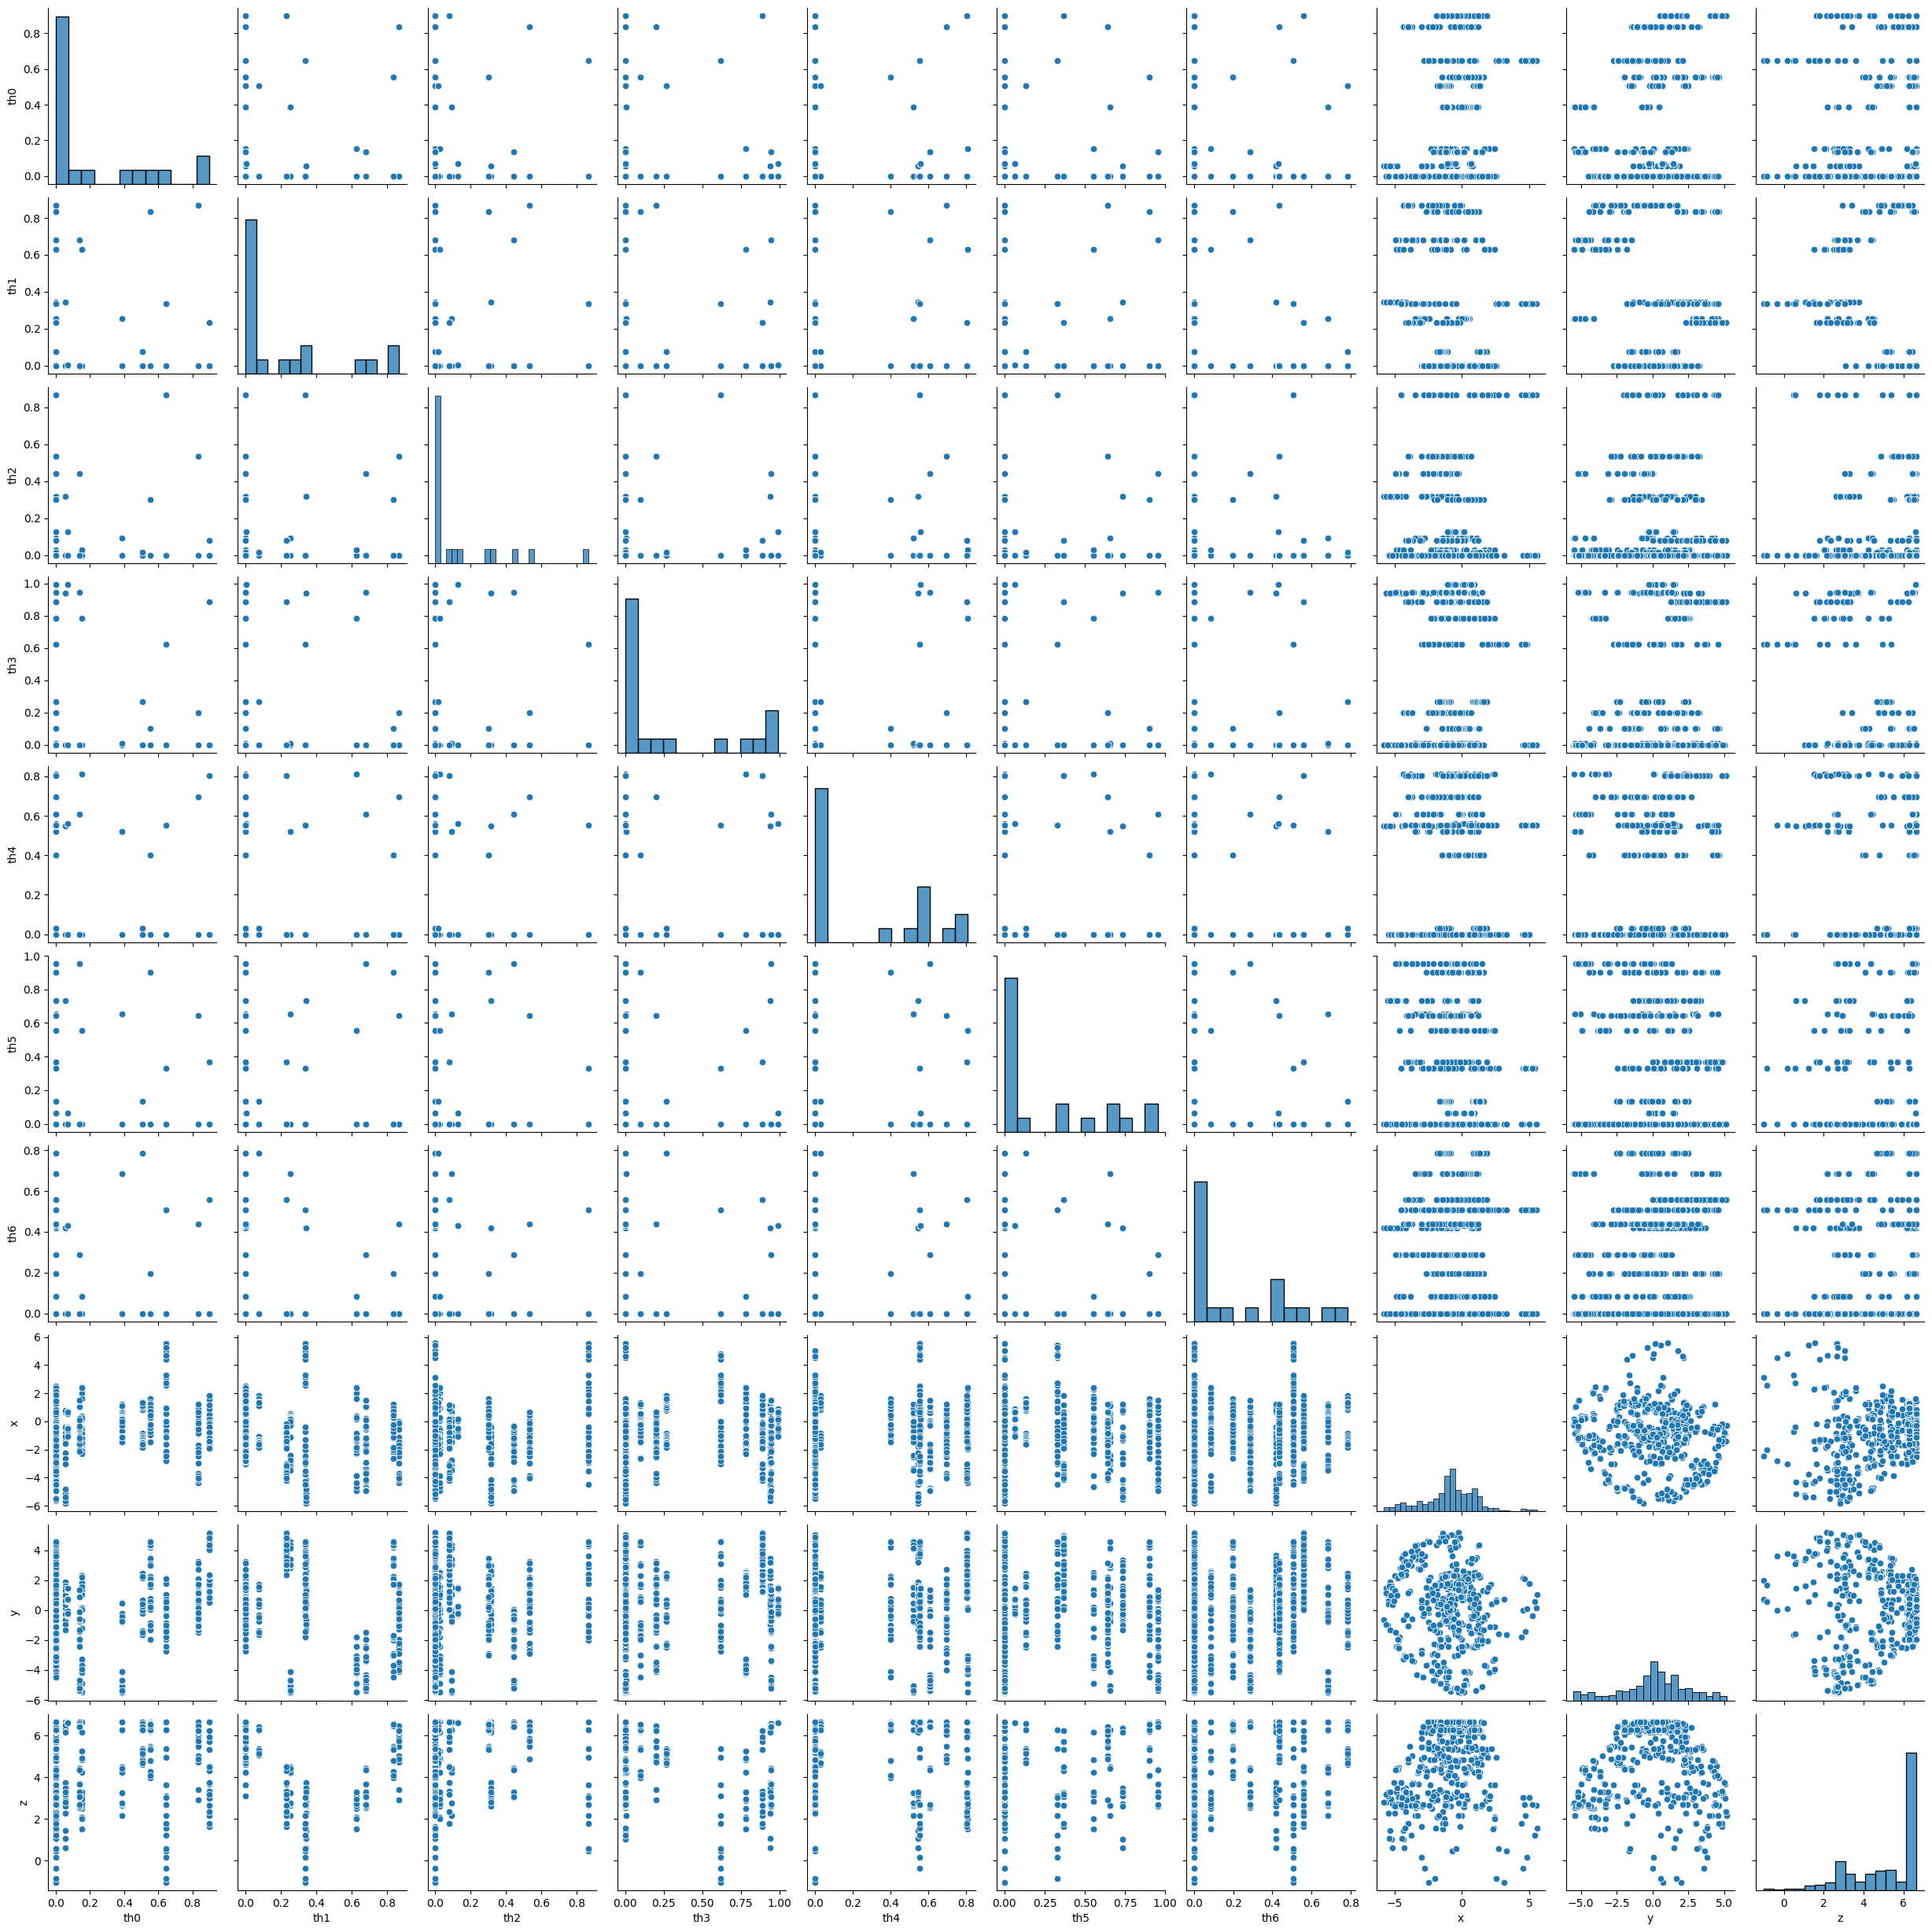

In [38]:
# Convert inputs to DataFrame Visualise
df = pd.DataFrame(features, columns=['th0', 'th1', 'th2', 'th3', 'th4', 'th5', 'th6'])

# Add a class label column (assuming the first column of 'outputs' indicates class 0)
#df['Class'] = labels[:, 0]  # This sets 1 for class 0 and 0 for class 1

df[['x', 'y', 'z']] = pd.DataFrame(labels, index=df.index)

# Use seaborn's pairplot
#sns.pairplot(df, hue='Class', palette='bright')
# Show the plot
#plt.show()

#for i in range(1, 4):
#sns.pairplot(df, x_vars=['th0', 'th0', 'th0', 'th0', 'th0', 'th0', 'th0'], y_vars=['x', 'y', 'z'])
sns.pairplot(df)
plt.savefig("plot.svg", format='svg')
plt.show()

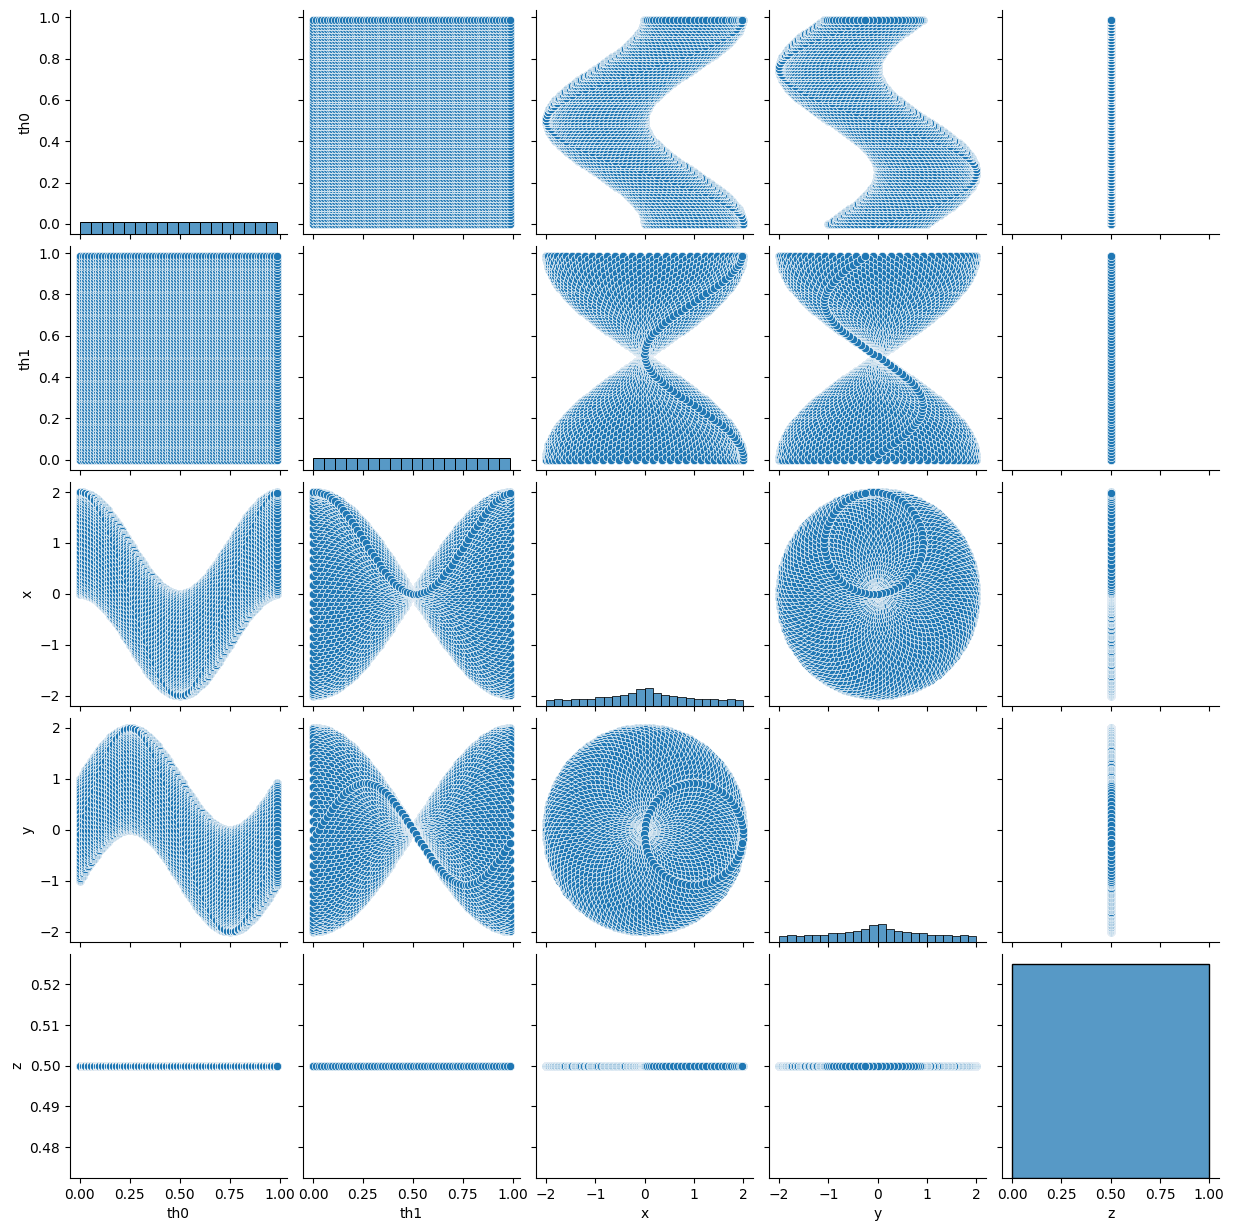

In [35]:
# Convert inputs to DataFrame
df = pd.DataFrame(labels, columns=['th0', 'th1'])

# Add a class label column (assuming the first column of 'outputs' indicates class 0)
#df['Class'] = labels[:, 0]  # This sets 1 for class 0 and 0 for class 1

df[['x', 'y', 'z']] = pd.DataFrame(features, index=df.index)

# Use seaborn's pairplot
#sns.pairplot(df, hue='Class', palette='bright')
# Show the plot
#plt.show()

#for i in range(1, 4):
#sns.pairplot(df, x_vars=['th0', 'th0', 'th0', 'th0', 'th0', 'th0', 'th0'], y_vars=['x', 'y', 'z'])
sns.pairplot(df)
plt.savefig("plot.svg", format='svg')
plt.show()

In [93]:
# Simple dataset
features_dataset = tf.convert_to_tensor(features, dtype=tf.float32)
labels_dataset = tf.convert_to_tensor(labels, dtype=tf.float32)
print(labels_dataset, features_dataset)

tf.Tensor(
[[0.         0.        ]
 [0.         0.02777778]
 [0.         0.05555556]
 ...
 [0.9722222  0.9166667 ]
 [0.9722222  0.9444444 ]
 [0.9722222  0.9722222 ]], shape=(1296, 2), dtype=float32) tf.Tensor(
[[ 0.          0.          0.         ...  2.          0.
   0.5       ]
 [ 0.          0.          0.         ...  1.9848077   0.17364818
   0.5       ]
 [ 0.          0.          0.         ...  1.9396926   0.34202015
   0.5       ]
 ...
 [ 0.          0.          0.         ...  1.7508522  -0.8164358
   0.5       ]
 [ 0.          0.          0.         ...  1.8508332  -0.6736482
   0.5       ]
 [ 0.          0.          0.         ...  1.9245003  -0.51566833
   0.5       ]], shape=(1296, 12), dtype=float32)


In [67]:
#data = np.load('DaneTh1_191223_V2.npy')
#features = np.load('Danef.npy')
#labels = np.load('Danel.npy')
features_x_dataset = tf.convert_to_tensor(features_x, dtype=tf.float32)
features_y_dataset = tf.convert_to_tensor(features_y, dtype=tf.float32)
features_z_dataset = tf.convert_to_tensor(features_z, dtype=tf.float32)
labels_dataset = tf.convert_to_tensor(labels, dtype=tf.float32)
print(labels_dataset, features_x_dataset)

tf.Tensor(
[[0.         0.        ]
 [0.         0.01388889]
 [0.         0.02777778]
 ...
 [0.9861111  0.9583333 ]
 [0.9861111  0.9722222 ]
 [0.9861111  0.9861111 ]], shape=(5184, 2), dtype=float32) tf.Tensor(
[[2.       ]
 [1.9961947]
 [1.9848077]
 ...
 [1.9358873]
 [1.9621205]
 [1.9810024]], shape=(5184, 1), dtype=float32)


In [91]:
# Split the dataset into training and validation sets SIMPLE
X_train, X_val, y_train, y_val = train_test_split(features, labels, shuffle=True, test_size=0.2)
# using the training data as validation data
#X_train = labels
#y_train = features
#X_val = X_train
#y_val = y_train
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(160000, 8) (160000, 2)
(40000, 8) (40000, 2)


In [360]:
# testing datasets
raw_test = np.load('Datasets/simple_ssl_kmeans_test_far.npy')
print(type(raw_test), type(raw_test[0]), len(raw_test), len(raw_test[0]))
print(raw_test[0])

X_test_far = raw_test[:, :8]
y_test_far = raw_test[:, 8:]

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 282 10
[-7.05260063e-02  1.24335829e-01  5.00000000e-01 -4.32828389e-01
  8.16915020e-01  5.00000000e-01  1.80383889e+02  2.35064444e+02
  2.05464286e+02  1.88197143e+02]


In [604]:
# New data loading
# simple_regular_v1
# simple_kmeans_v1
# simple_ssl_kmeans_v1
# simple_ssl_kmeans_v2
# simple_ssl_kmeans_v3
# simple_regular_v1_cyclical
# simple_kmeans_v1_cyclical
# simple_ssl_kmeans_v1_cyclical
# simple_ssl_kmeans_v2_cyclical
# simple_ssl_kmeans_v3_cyclical
# complex_ssl_kmeans_v1
# complex_kmeans
# complex_kmeans_cyclical
# complex_ssl_mixed
# complex_ssl_mixed_cyclical
# complex_ssl_mixed_v2
raw_data = np.load('Datasets/complex_ssl_mixed_cyclical_v2.npy')
print(type(raw_data), type(raw_data[0]), len(raw_data), len(raw_data[0]))
print(raw_data[0])

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 486210 34
[ 0.04133532  1.76959938  6.01495569 -0.03889325  1.61257242  6.02785303
 -0.97333924 -0.22937027 -0.98917011  0.14677364 -0.04745513 -0.99887337
  0.97121748  0.23819445  0.80187994  0.5974852   0.83590317  0.54887693
  0.83943021  0.5434675  -0.96995699 -0.24327645 -0.98924682  0.14625569
 -0.11181582 -0.99372895  0.96325638  0.2685836   0.80737244  0.59004216
  0.83781402  0.54595574  0.84395364  0.53641612]


In [605]:
# Split the data into features and labels
features = raw_data[:, :20]  # First x columns are features [x, y, z]
labels = raw_data[:, 20:]    # other columns are labels

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [606]:
batch_size = 8192
batch_size_test = 8192

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.cache()
train_set = train_set.shuffle(buffer_size=len(train_set))
train_set = train_set.batch(batch_size, drop_remainder=False)
#train_set = train_set.repeat()
train_set = train_set.prefetch(tf.data.AUTOTUNE)

test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.cache()
test_set = test_set.shuffle(buffer_size=len(test_set))
test_set = test_set.batch(batch_size_test, drop_remainder=True)
test_set = test_set.prefetch(tf.data.AUTOTUNE)

In [607]:
for (feature, label) in train_set:
    print(feature.numpy().shape, label.numpy().shape, np.max(label, axis=0))
    break

(8192, 20) (8192, 14) [0.99999998 1.         1.         1.         0.99999976 1.
 1.         1.         0.99999893 1.         0.99999994 1.
 1.         1.        ]


In [608]:
for (feature, label) in test_set:
    print(feature.numpy().shape, label.numpy().shape, np.max(label, axis=0))
    break

(8192, 20) (8192, 14) [1.         1.         1.         1.         0.99999998 1.
 1.         1.         0.99999998 1.         0.99999994 1.
 1.         1.        ]


Model: "functional_422"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_373 (Dense)   │ (None, 64)        │        896 │ input_layer_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_258         │ (None, 64)        │          0 │ dense_373[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_374 (Dense)   │ (None, 32)        │      2,080 │ dropout_258[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_377 (Dense)   │ (None, 32)        │      2,080 │ dropout_258[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_380 (Dense)   │ (None, 32)        │      2,080 │ dropout_258[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_383 (Dense)   │ (None, 32)        │      2,080 │ dropout_258[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_386 (Dense)   │ (None, 32)        │      2,080 │ dropout_258[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_389 (Dense)   │ (None, 32)        │      2,080 │ dropout_258[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_259         │ (None, 32)        │          0 │ dense_374[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_261         │ (None, 32)        │          0 │ dense_377[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_263         │ (None, 32)        │          0 │ dense_380[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_265         │ (None, 32)        │          0 │ dense_383[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_267         │ (None, 32)        │          0 │ dense_386[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_269         │ (None, 32)        │          0 │ dense_389[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_375 (Dense)   │ (None, 32)        │      1,056 │ dropout_259[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_378 (Dense)   │ (None, 32)        │      1,056 │ dropout_261[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_381 (Dense)   │ (None, 32)        │      1,056 │ dropout_263[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_384 (Dense)   │ (None, 32)        │      1,056 │ dropout_265[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_387 (Dense)   │ (None, 32)        │      1,056 │ dropout_267[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_390 (Dense)   │ (None, 32)        │      1,056 │ dropout_269[0][0

 Total params: 19,910 (77.77 KB)

 Trainable params: 19,910 (77.77 KB)

 Non-trainable params: 0 (0.00 B)

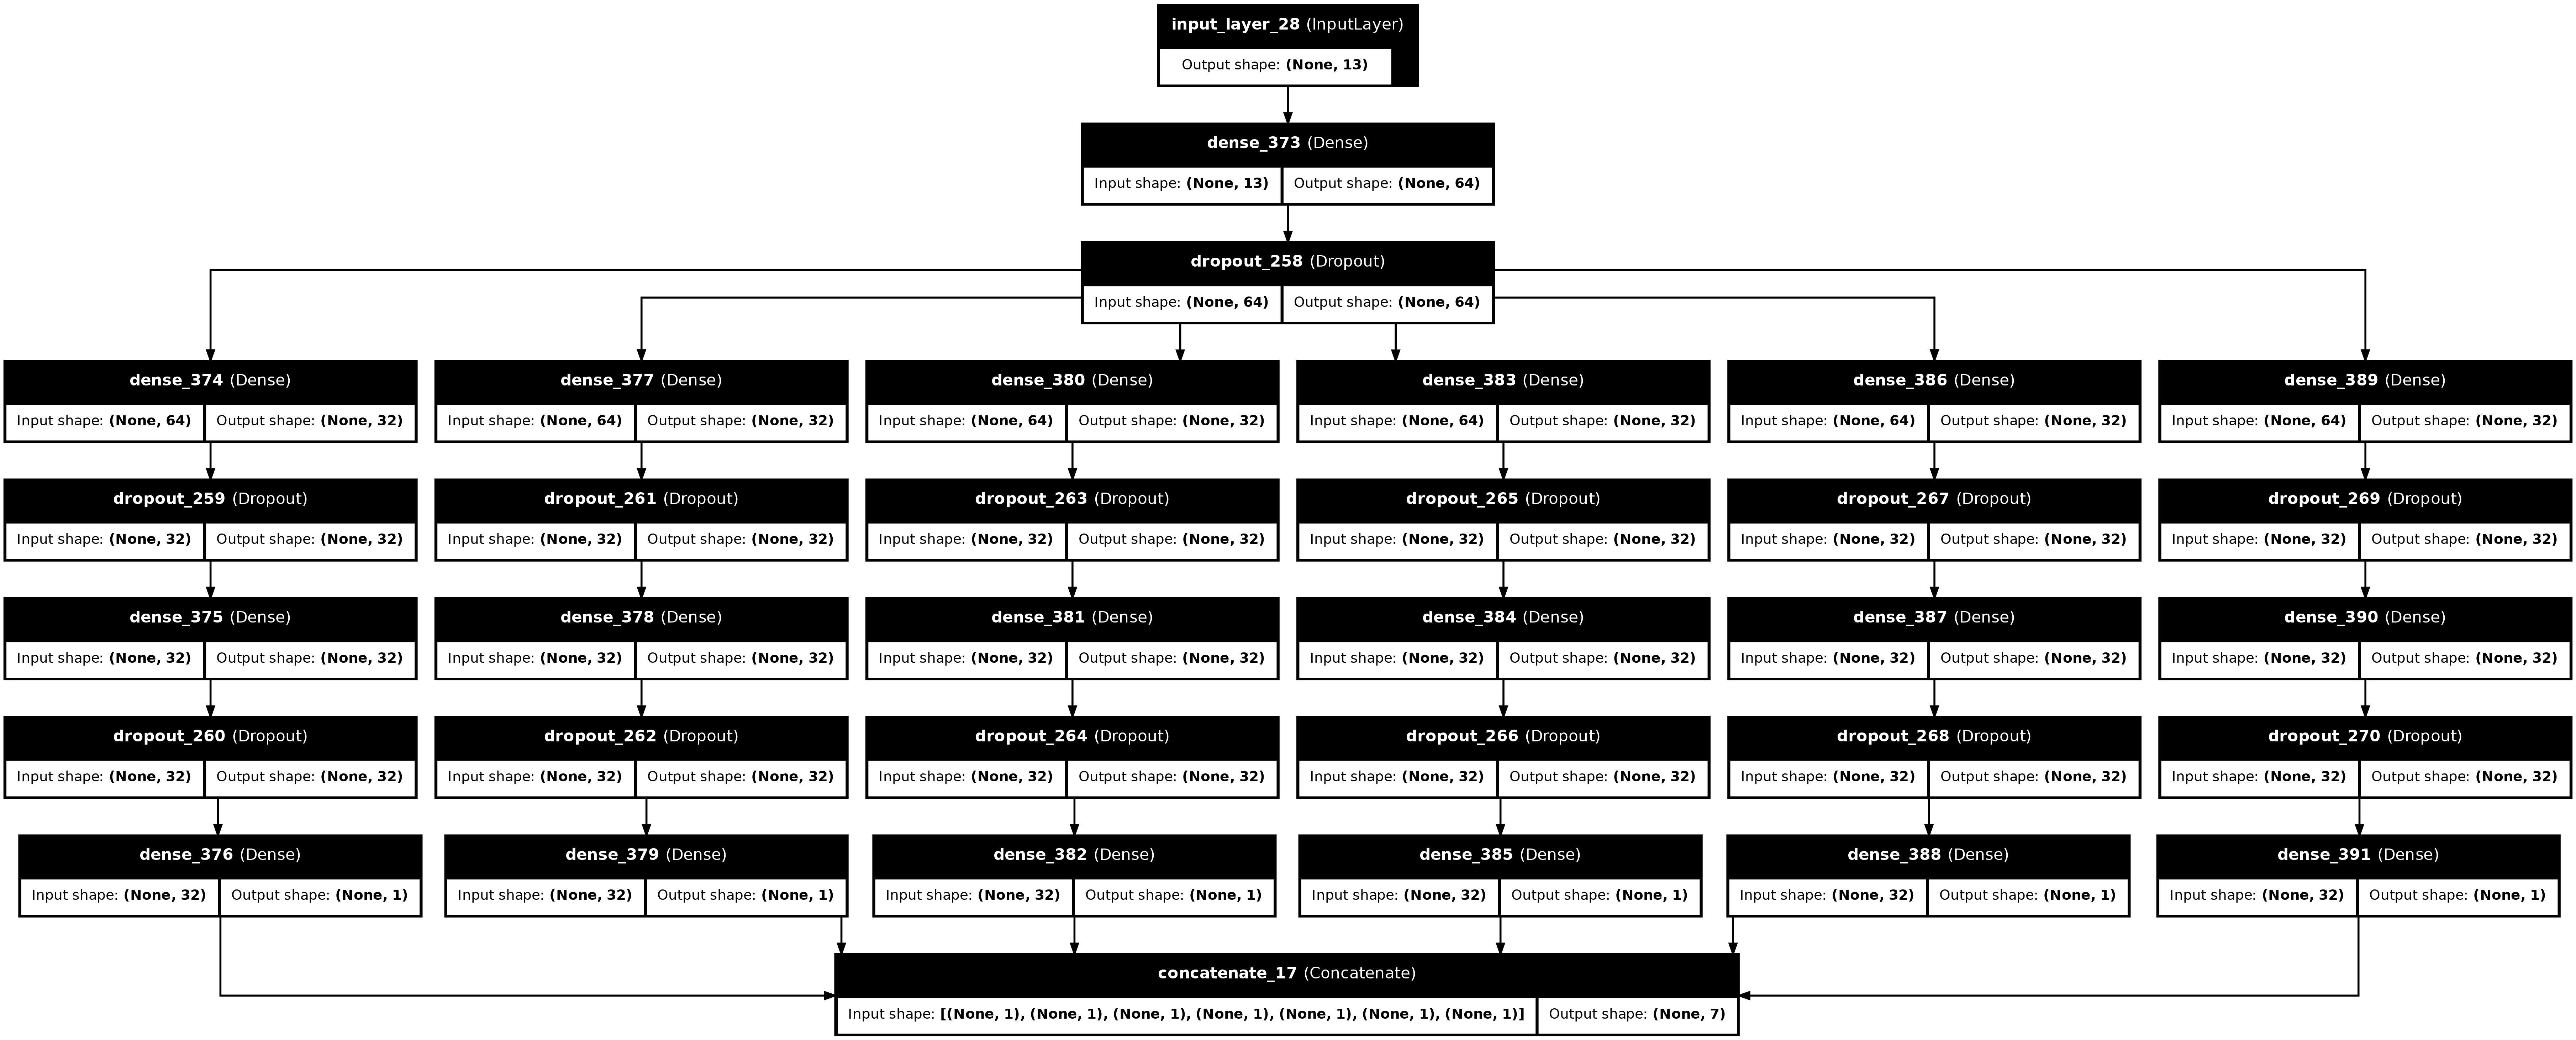

In [563]:
# paralel model

l1_value = 0.0001
l2_value = 0.001

tanh_layers = 32
swish_layers = 32
output_layers = 1
global_dropout = 0.1

# Create L1L2 regularizer using the defined values
regularizer = regularizers.L1L2(l1=l1_value, l2=l2_value)

# Create the Sequential model
model = Sequential()

input_layer = Input(shape=(13,))

# Initial shared dense layer
x = Dense(64, activation='linear', kernel_regularizer=regularizer)(input_layer)
x = Dropout(0.2)(x)

# Branch 1 for the first output
branch_1 = Dense(tanh_layers, activation='tanh', kernel_regularizer=regularizer)(x)
branch_1 = Dropout(global_dropout)(branch_1)
branch_1 = Dense(swish_layers, activation='swish', kernel_regularizer=regularizer)(branch_1)
branch_1 = Dropout(global_dropout)(branch_1)
output_1 = Dense(output_layers, activation='linear', kernel_regularizer=regularizer)(branch_1)

# Branch 2 for the second output
branch_2 = Dense(tanh_layers, activation='tanh', kernel_regularizer=regularizer)(x)
branch_2 = Dropout(global_dropout)(branch_2)
branch_2 = Dense(swish_layers, activation='swish', kernel_regularizer=regularizer)(branch_2)
branch_2 = Dropout(global_dropout)(branch_2)
output_2 = Dense(output_layers, activation='linear', kernel_regularizer=regularizer)(branch_2)

# Branch 3 for the second output
branch_3 = Dense(tanh_layers, activation='tanh', kernel_regularizer=regularizer)(x)
branch_3 = Dropout(global_dropout)(branch_3)
branch_3 = Dense(swish_layers, activation='swish', kernel_regularizer=regularizer)(branch_3)
branch_3 = Dropout(global_dropout)(branch_3)
output_3 = Dense(output_layers, activation='linear', kernel_regularizer=regularizer)(branch_3)

# Branch 4 for the second output
branch_4 = Dense(tanh_layers, activation='tanh', kernel_regularizer=regularizer)(x)
branch_4 = Dropout(global_dropout)(branch_4)
branch_4 = Dense(swish_layers, activation='swish', kernel_regularizer=regularizer)(branch_4)
branch_4 = Dropout(global_dropout)(branch_4)
output_4 = Dense(output_layers, activation='linear', kernel_regularizer=regularizer)(branch_4)

# Branch 5 for the second output
branch_5 = Dense(tanh_layers, activation='tanh', kernel_regularizer=regularizer)(x)
branch_5 = Dropout(global_dropout)(branch_5)
branch_5 = Dense(swish_layers, activation='swish', kernel_regularizer=regularizer)(branch_5)
branch_5 = Dropout(global_dropout)(branch_5)
output_5 = Dense(output_layers, activation='linear', kernel_regularizer=regularizer)(branch_5)

# Branch 6 for the second output
branch_6 = Dense(tanh_layers, activation='tanh', kernel_regularizer=regularizer)(x)
branch_6 = Dropout(global_dropout)(branch_6)
branch_6 = Dense(swish_layers, activation='swish', kernel_regularizer=regularizer)(branch_6)
branch_6 = Dropout(global_dropout)(branch_6)
output_6 = Dense(output_layers, activation='linear', kernel_regularizer=regularizer)(branch_6)

# Branch 7 for the second output
branch_7 = Dense(tanh_layers, activation='tanh', kernel_regularizer=regularizer)(x)
branch_7 = Dropout(global_dropout)(branch_7)
branch_7 = Dense(swish_layers, activation='swish', kernel_regularizer=regularizer)(branch_7)
branch_7 = Dropout(global_dropout)(branch_7)
output_7 = Dense(output_layers, activation='linear', kernel_regularizer=regularizer)(branch_7)

# Concatenate the outputs of the two branches
output = concatenate([output_1, output_2, output_3, output_4, output_5, output_6, output_1])

# Create the model
model = Model(inputs=input_layer, outputs=output)

# Compile the model with Nadam optimizer and a specified learning rate
model.compile(
    optimizer=Nadam(learning_rate=0.006),
    loss=Huber(delta=0.5),  # Huber loss combining MSE and MAE
    metrics=['mae']
)

# Summary of the model
model.summary()

# Create a plot of the model architecture
plot_model(model, to_file='branching_model_architecture.png', show_shapes=True, show_layer_names=True)

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ linear_layer_1 (Dense)          │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_1 (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tanh_layer_2 (Dense)            │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_2 (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swish_layer_3 (Dense)           │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_3 (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tanh_layer_4 (Dense)            │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_4 (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linear_layer_5 (Dense)          │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,734 (57.55 KB)

 Trainable params: 14,734 (57.55 KB)

 Non-trainable params: 0 (0.00 B)

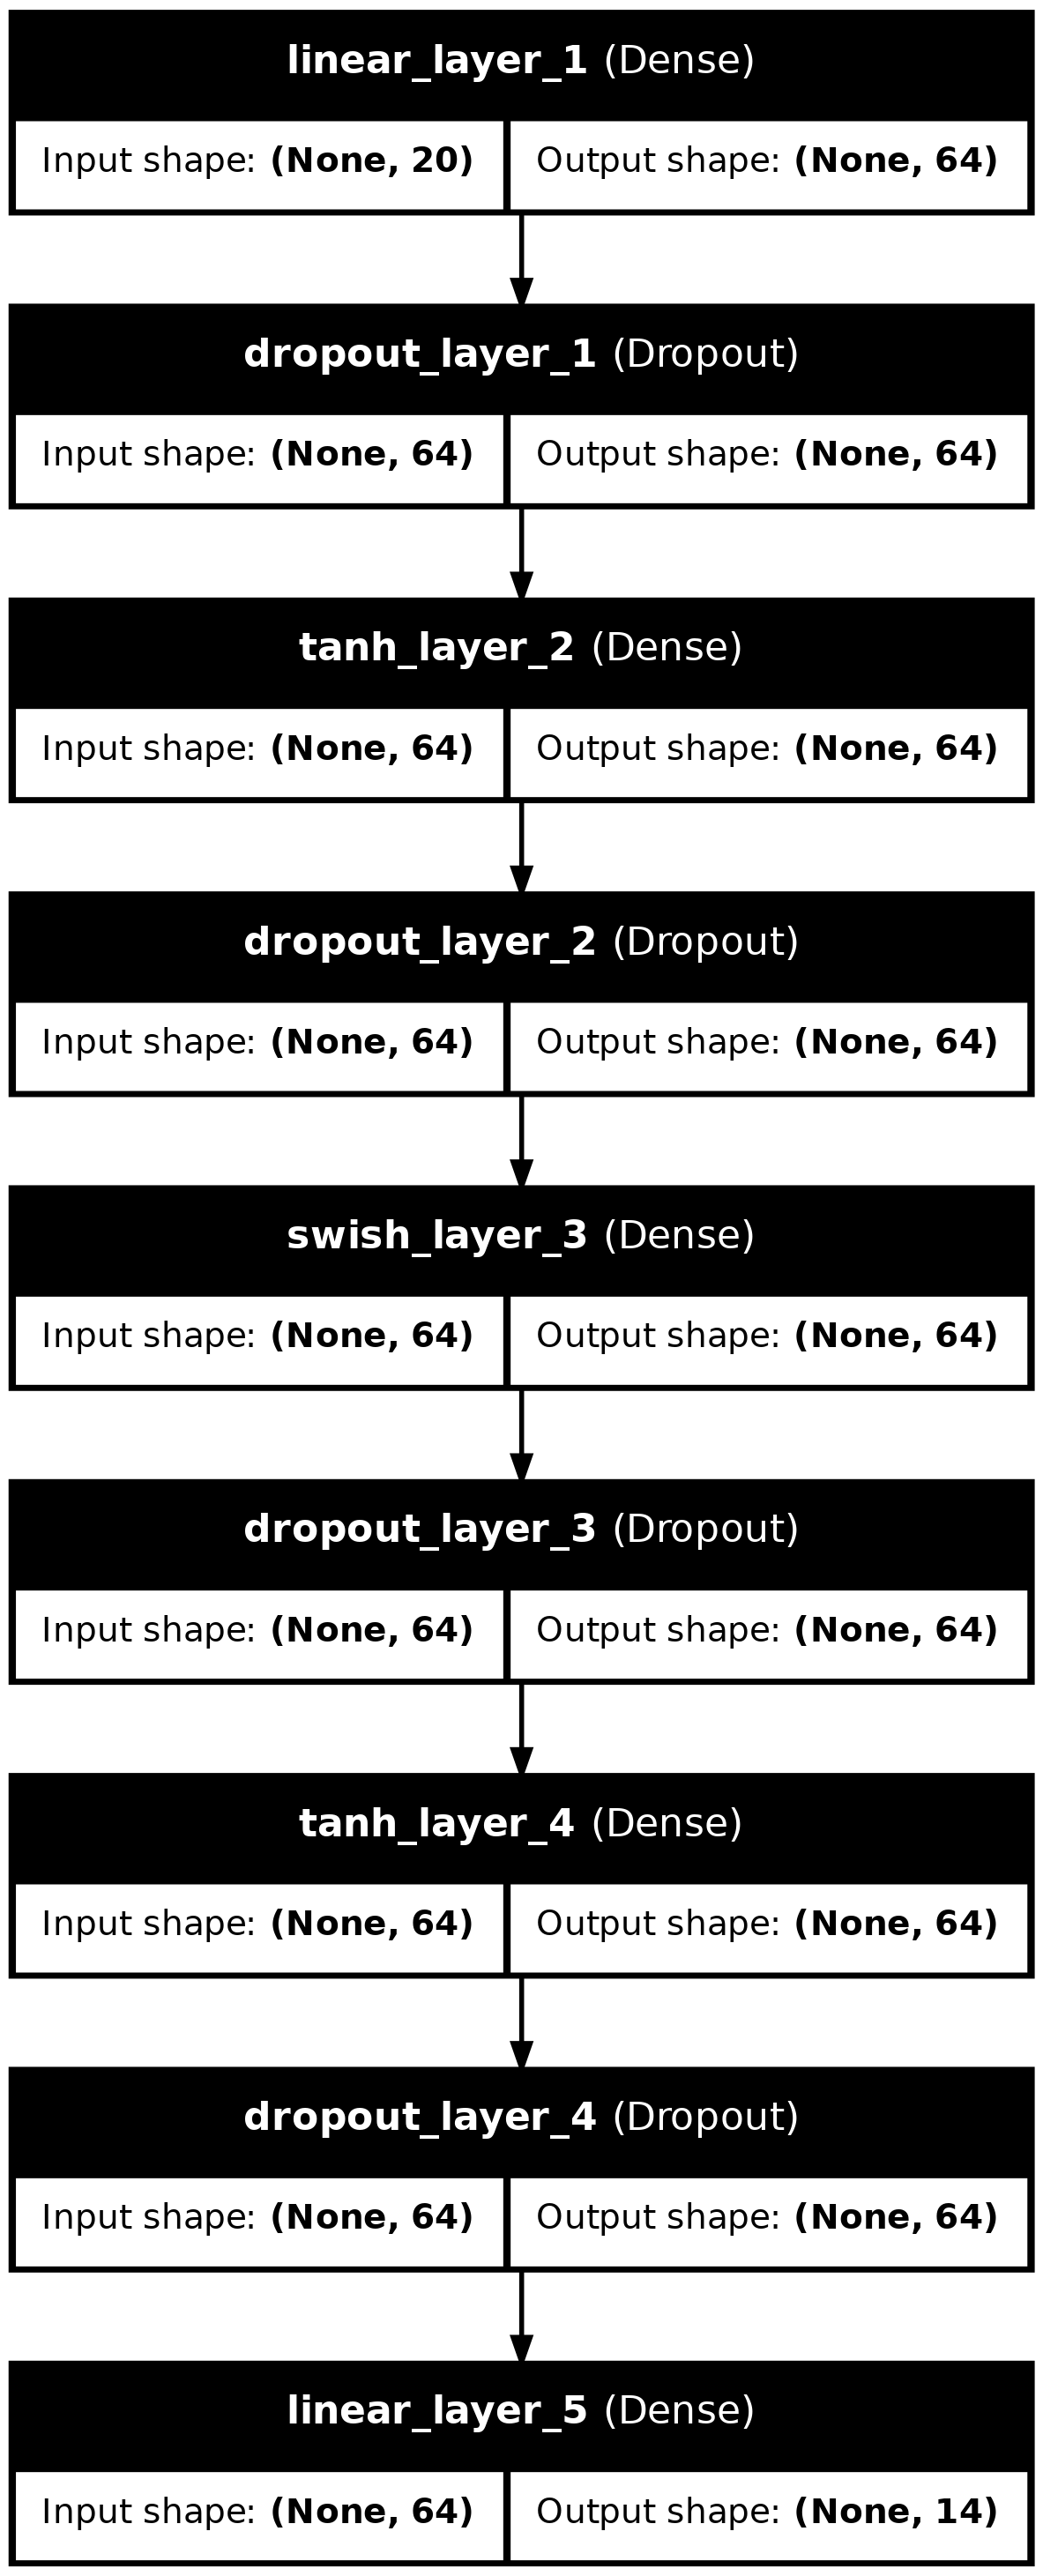

In [603]:
# Simple model with droput
l1_value = 0.0002
l2_value = 0.002

# Define the custom Swish function with beta
def swish_beta(x, beta=5.0):
    return x * tf.nn.sigmoid(beta * x)

# Wrap it in a lambda function to pass as the activation
swish_activation = lambda x: swish_beta(x, beta=5.0)

# Create L1L2 regularizer using the defined values
regularizer = regularizers.L1L2(l1=l1_value, l2=l2_value)

# Create the Sequential model
model = Sequential()

# Input layer with 3 features
model.add(Input(shape=(20,)))  # Input layer, no activation function specified (defaults to linear)

# Layer 1: Dense layer with 128 neurons, linear activation, with L1 and L2 regularization
model.add(Dense(64, activation='linear', kernel_regularizer=regularizer, name='linear_layer_1'))
model.add(Dropout(0.1, name='dropout_layer_1'))

# Layer 2: Dense layer with 128 neurons, tanh activation, with L1 and L2 regularization
model.add(Dense(64, activation='tanh', kernel_regularizer=regularizer, name='tanh_layer_2'))
model.add(Dropout(0.1, name='dropout_layer_2'))

# Layer 3: Dense layer with 128 neurons, swish activation, with L1 and L2 regularization
model.add(Dense(64, activation=swish_activation, kernel_regularizer=regularizer, name='swish_layer_3'))
model.add(Dropout(0.1, name='dropout_layer_3'))

# Layer 4: Dense layer with 128 neurons, tanh activation, with L1 and L2 regularization
model.add(Dense(64, activation='tanh', kernel_regularizer=regularizer, name='tanh_layer_4'))
model.add(Dropout(0.1, name='dropout_layer_4'))

# Layer 5: Dense layer with 7 neurons, linear activation (output layer), with L1 and L2 regularization
model.add(Dense(14, activation='linear', kernel_regularizer=regularizer, name='linear_layer_5'))

# Compile the model with Nadam optimizer and a lower learning rate
model.compile(
    optimizer= Nadam(learning_rate=0.006),  # Nadam optimizer with a lower learning rate
    loss=Huber(delta=1.0),  # Mean Squared Error loss
    metrics=['mae']  # Mean Absolute Error
)

# Summary of the model
model.summary()

# Create a plot of the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [101]:
class PlotTraining(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}
        self.fig, self.axs = plt.subplots(1, 2, figsize=(12, 5))
        plt.ion()  # Turn on interactive mode for live updates

    def on_epoch_end(self, epoch, logs=None):
        # Only update the plot every 10th epoch
        if (epoch + 1) % 10 == 0:
            self.epochs.append(epoch)
            for key in self.history.keys():
                if key in logs:
                    self.history[key].append(logs.get(key))

            self.axs[0].clear()
            self.axs[1].clear()

            # Plot loss (MSE) with logarithmic scaling
            self.axs[0].plot(self.epochs, self.history['loss'], label='Training MSE')
            if 'val_loss' in self.history and len(self.history['val_loss']) > 0:
                self.axs[0].plot(self.epochs, self.history['val_loss'], label='Validation MSE')
            self.axs[0].set_yscale('log')  # Apply logarithmic scaling to the y-axis
            self.axs[0].legend()
            self.axs[0].set_title('Mean Squared Error (MSE)')
            self.axs[0].set_xlabel('Epochs')
            self.axs[0].set_ylabel('MSE (log scale)')
            self.axs[0].grid(True)  # Add grid lines

            # Plot Mean Absolute Error (MAE) with logarithmic scaling
            self.axs[1].plot(self.epochs, self.history['mae'], label='Training MAE')
            if 'val_mae' in self.history and len(self.history['val_mae']) > 0:
                self.axs[1].plot(self.epochs, self.history['val_mae'], label='Validation MAE')
            self.axs[1].set_yscale('log')  # Apply logarithmic scaling to the y-axis
            self.axs[1].legend()
            self.axs[1].set_title('Mean Absolute Error (MAE)')
            self.axs[1].set_xlabel('Epochs')
            self.axs[1].set_ylabel('MAE (log scale)')
            self.axs[1].grid(True)  # Add grid lines

            clear_output(wait=True)  # Clear the previous plot
            display(plt.gcf())  # Display the current figure

    def on_train_end(self, logs=None):
        plt.ioff()  # Turn off interactive mode
        plt.show()  # Show the final plot

In [146]:
class PlotTraining(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}
        self.fig, self.axs = plt.subplots(1, 2, figsize=(12, 5))
        plt.ion()  # Turn on interactive mode for live updates

    def on_epoch_end(self, epoch, logs=None):
        # Only update the plot every 10th epoch
        if (epoch + 1) % 10 == 0:
            self.epochs.append(epoch)
            for key in self.history.keys():
                if key in logs:
                    self.history[key].append(logs.get(key))

            self.axs[0].clear()
            self.axs[1].clear()

            # Plot loss (MSE) without logarithmic scaling
            self.axs[0].plot(self.epochs, self.history['loss'], label='Training MSE')
            if 'val_loss' in self.history and len(self.history['val_loss']) > 0:
                self.axs[0].plot(self.epochs, self.history['val_loss'], label='Validation MSE')
            self.axs[0].legend()
            self.axs[0].set_title('Mean Squared Error (MSE)')
            self.axs[0].set_xlabel('Epochs')
            self.axs[0].set_ylabel('MSE')
            self.axs[0].grid(True)  # Add grid lines

            # Plot Mean Absolute Error (MAE) without logarithmic scaling
            self.axs[1].plot(self.epochs, self.history['mae'], label='Training MAE')
            if 'val_mae' in self.history and len(self.history['val_mae']) > 0:
                self.axs[1].plot(self.epochs, self.history['val_mae'], label='Validation MAE')
            self.axs[1].legend()
            self.axs[1].set_title('Mean Absolute Error (MAE)')
            self.axs[1].set_xlabel('Epochs')
            self.axs[1].set_ylabel('MAE')
            self.axs[1].grid(True)  # Add grid lines

            clear_output(wait=True)  # Clear the previous plot
            display(plt.gcf())  # Display the current figure

    def on_train_end(self, logs=None):
        plt.ioff()  # Turn off interactive mode
        plt.show()  # Show the final plot

In [163]:
class PlotTraining(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}
        self.fig, self.axs = plt.subplots(1, 2, figsize=(12, 5))
        plt.ion()  # Turn on interactive mode for live updates

    def on_epoch_end(self, epoch, logs=None):
        # Only update the plot every 10th epoch
        if (epoch + 1) % 30 == 0:
            self.epochs.append(epoch)

            for key in self.history.keys():
                if key in logs:
                    self.history[key].append(logs.get(key))

            self.axs[0].clear()
            self.axs[1].clear()

            # Plot loss without logarithmic scaling
            if len(self.epochs) > 0 and len(self.history['loss']) > 0:
                self.axs[0].plot(self.epochs, self.history['loss'], label='Training Loss')
            if len(self.epochs) > 0 and len(self.history['val_loss']) > 0:
                self.axs[0].plot(self.epochs, self.history['val_loss'], label='Validation Loss')
            self.axs[0].legend()
            self.axs[0].set_title('Loss')
            self.axs[0].set_xlabel('Epochs')
            self.axs[0].set_ylabel('Loss')
            self.axs[0].grid(True)  # Add grid lines

            # Plot Mean Absolute Error (MAE) without logarithmic scaling
            if len(self.epochs) > 0 and len(self.history['mae']) > 0:
                self.axs[1].plot(self.epochs, self.history['mae'], label='Training MAE')
            if len(self.epochs) > 0 and len(self.history['val_mae']) > 0:
                self.axs[1].plot(self.epochs, self.history['val_mae'], label='Validation MAE')
            self.axs[1].legend()
            self.axs[1].set_title('Mean Absolute Error (MAE)')
            self.axs[1].set_xlabel('Epochs')
            self.axs[1].set_ylabel('MAE')
            self.axs[1].grid(True)  # Add grid lines

            clear_output(wait=True)  # Clear the previous plot
            display(plt.gcf())  # Display the current figure

    def on_train_end(self, logs=None):
        plt.ioff()  # Turn off interactive mode
        plt.show()  # Show the final plot

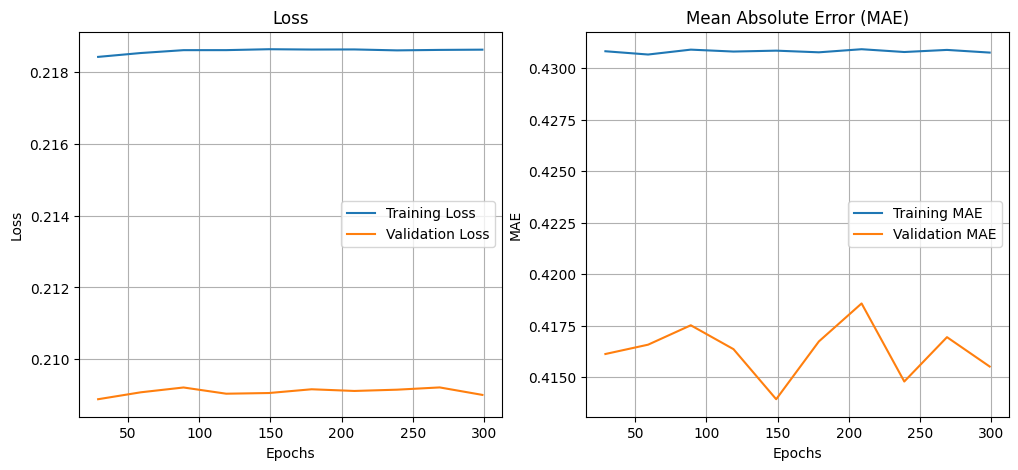

Epoch 318: early stopping
Restoring model weights from the end of the best epoch: 18.


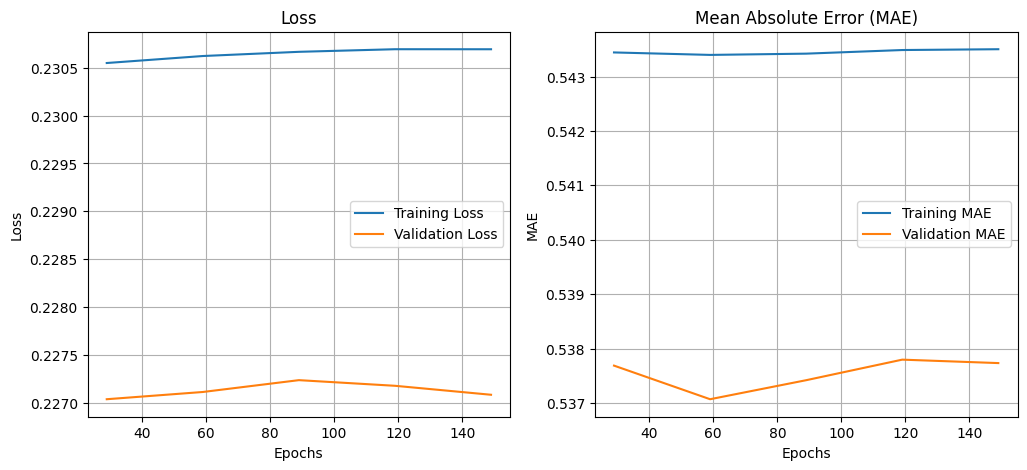

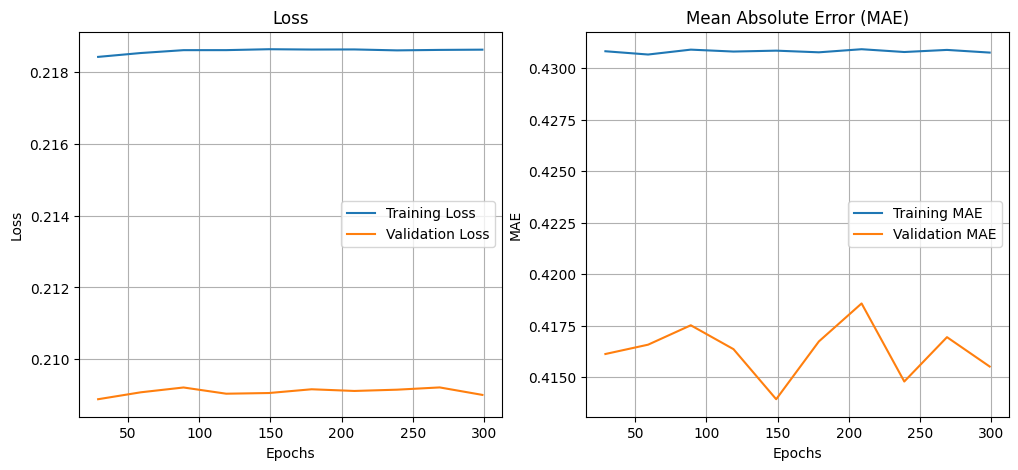

In [609]:
num_epochs = 20000

# Create an instance of the PlotTraining callback
plot_training_callback = PlotTraining()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation Huber loss
    patience=300,              # Stop after 100 epochs with no improvement
    verbose=1,                 # Print a message when stopping
    mode='min',                # Specify that we want to minimize the monitored metric
    restore_best_weights=True  # Restore model weights from the epoch with the best loss
)

# Fit the model using the variables for epochs and batch size
history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=num_epochs,            # Number of epochs
    batch_size=batch_size,        # Batch size
    callbacks=[early_stopping_callback, plot_training_callback],
    verbose=0
)

In [610]:
# Save the model in .keras format
model.save('Datasets/Models/complex_kmeans_ssl_simple_cyclical_mod_swish.keras')

/home/marek/TF_215/lib/python3.11/site-packages/keras/src/activations/__init__.py:54: UserWarning:

The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: swish_activation = lambda x: swish_beta(x, beta=5.0)




In [589]:
# Load the saved model
loaded_model = tf.keras.models.load_model('Datasets/Models/complex_kmeans_ssl_simple_cyclical.keras')

# Optionally, you can display the model's architecture
loaded_model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ linear_layer_1 (Dense)          │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_1 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tanh_layer_2 (Dense)            │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_2 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swish_layer_3 (Dense)           │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_3 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tanh_layer_4 (Dense)            │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_4 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linear_layer_5 (Dense)          │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,093 (633.18 KB)

 Trainable params: 54,030 (211.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 108,063 (422.12 KB)

In [272]:
# Function to encode angles with sin and cos
def encode_angles_with_sin_cos(arr):
    encoded_array = []
    
    for subvector in arr:
        # Extract the last two elements (angles)
        angle1 = subvector[-2]
        angle2 = subvector[-1]
        
        # Convert angles to radians
        angle1_rad = np.deg2rad(angle1)
        angle2_rad = np.deg2rad(angle2)
        
        # Compute sine and cosine of each angle
        e1a1 = np.sin(angle1_rad)
        e2a1 = np.cos(angle1_rad)
        e1a2 = np.sin(angle2_rad)
        e2a2 = np.cos(angle2_rad)
        
        # Create the new subvector with encoded angles
        new_subvector = np.concatenate((subvector[:-2], [e1a1, e2a1, e1a2, e2a2]))
        encoded_array.append(new_subvector)
    
    return np.array(encoded_array)

def encode_angles_with_sin_cos_ssl_7(arr):
    encoded_array = []
    
    for subvector in arr:
        encoded_angles = []
        
        # Process the last 14 elements (angles) for 14 joints
        for i in range(7):
            angle = subvector[-7 + i]  # Extract each angle
            
            # Convert angle to radians
            angle_rad = np.deg2rad(angle)
            
            # Compute sine and cosine of the angle
            e1 = np.sin(angle_rad)
            e2 = np.cos(angle_rad)
            
            # Append sine and cosine to the encoded angles list
            encoded_angles.extend([e1, e2])
        
        # Create the new subvector with encoded angles
        new_subvector = np.concatenate((subvector[:-7], encoded_angles))
        encoded_array.append(new_subvector)
    
    return np.array(encoded_array)

def encode_angles_with_sin_cos_ssl_14(arr):
    encoded_array = []
    
    for subvector in arr:
        encoded_angles = []
        
        # Process the last 14 elements (angles) for 14 joints
        for i in range(14):
            angle = subvector[-14 + i]  # Extract each angle
            
            # Convert angle to radians
            angle_rad = np.deg2rad(angle)
            
            # Compute sine and cosine of the angle
            e1 = np.sin(angle_rad)
            e2 = np.cos(angle_rad)
            
            # Append sine and cosine to the encoded angles list
            encoded_angles.extend([e1, e2])
        
        # Create the new subvector with encoded angles
        new_subvector = np.concatenate((subvector[:-14], encoded_angles))
        encoded_array.append(new_subvector)
    
    return np.array(encoded_array)

def encode_angles_with_sin_cos_ssl(arr):
    encoded_array = []
    
    for subvector in arr:
        # Extract the last four elements (angles)
        angle1 = subvector[-4]
        angle2 = subvector[-3]
        angle3 = subvector[-2]
        angle4 = subvector[-1]
        
        # Convert angles to radians
        angle1_rad = np.deg2rad(angle1)
        angle2_rad = np.deg2rad(angle2)
        angle3_rad = np.deg2rad(angle3)
        angle4_rad = np.deg2rad(angle4)
        
        # Compute sine and cosine of each angle
        e1a1 = np.sin(angle1_rad)
        e2a1 = np.cos(angle1_rad)
        e1a2 = np.sin(angle2_rad)
        e2a2 = np.cos(angle2_rad)
        e1a3 = np.sin(angle3_rad)
        e2a3 = np.cos(angle3_rad)
        e1a4 = np.sin(angle4_rad)
        e2a4 = np.cos(angle4_rad)
        
        # Create the new subvector with encoded angles
        new_subvector = np.concatenate((subvector[:-4], [e1a1, e2a1, e1a2, e2a2, e1a3, e2a3, e1a4, e2a4]))
        encoded_array.append(new_subvector)
    
    return np.array(encoded_array)
    
# Function to decode sin and cos back to angles
def decode_angles_from_sin_cos(arr):
    decoded_array = []
    
    for subvector in arr:
        # Extract sine and cosine values
        e1a1 = subvector[-4]
        e2a1 = subvector[-3]
        e1a2 = subvector[-2]
        e2a2 = subvector[-1]
        
        # Reconstruct angles in radians
        angle1_rad = np.arctan2(e1a1, e2a1)
        angle2_rad = np.arctan2(e1a2, e2a2)
        
        # Convert back to degrees
        angle1 = np.rad2deg(angle1_rad)
        angle2 = np.rad2deg(angle2_rad)
        
        # Ensure angles are in the range [0, 360]
        if angle1 < 0:
            angle1 += 360
        if angle2 < 0:
            angle2 += 360
        
        # Create the new subvector with decoded angles
        new_subvector = np.concatenate((subvector[:-4], [angle1, angle2]))
        decoded_array.append(new_subvector)
    
    return np.array(decoded_array)

In [599]:
raw_data = np.load('Datasets/complex_point_test_ssl_far.npy')
X_test = raw_data[:, :13]
y_test = raw_data[:, 13:]
print(len(X_test), len(X_test[0]), X_test[0])
print(len(y_test), len(y_test[0]), y_test[0])

166 13 [ 3.49589637e+00 -3.70210579e+00  2.50601201e+00 -3.62160887e-02
 -4.58722701e+00  1.86748157e-02  1.36820000e+02  1.00990000e+02
  4.67700000e+01  1.20800000e+02  1.53040000e+02  1.18510000e+02
  5.74900000e+01]
166 7 [106.52 174.57  57.03 239.8   95.65 155.77  82.01]


In [600]:
#encoded_data = encode_angles_with_sin_cos(raw_data)
#encoded_data_ssl = encode_angles_with_sin_cos_ssl(raw_data)
#encoded_data_7 = encode_angles_with_sin_cos_ssl_7(raw_data)
encoded_data_14 = encode_angles_with_sin_cos_ssl_14(raw_data)

In [601]:
X_test = encoded_data_14[:, :20]
y_test = encoded_data_14[:, 20:]
print(len(X_test), len(X_test[0]), X_test[0])
print(len(y_test), len(y_test[0]), y_test[0])

166 20 [ 3.49589637 -3.70210579  2.50601201 -0.03621609 -4.58722701  0.01867482
  0.68429261 -0.72920754  0.98166047 -0.19063767  0.7286101   0.6849287
  0.8589599  -0.51204286  0.45336835 -0.89132325  0.87873382 -0.47731214
  0.84329766  0.5374468 ]
166 14 [ 0.95872054 -0.28435002  0.09462958 -0.99551255  0.83895563  0.54419983
 -0.8642748  -0.50301995  0.99514186 -0.09845136  0.41040056 -0.91190536
  0.99029234  0.13900026]


In [602]:
# Get predictions
predictions = loaded_model.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae:.4f}")

# Assuming y_tests and predictions_list are lists of arrays from multiple runs
mae_list = []

# Loop through multiple runs (or cross-validation folds)
for y_t, prediction in zip(y_test, predictions):
    mae = mean_absolute_error(y_t, prediction)
    mae_list.append(mae)

# Calculate the standard deviation of the MAE
std_dev_mae = np.std(mae_list)
print(f"Standard Deviation of MAE: {std_dev_mae:.4f}")

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Mean Absolute Error: 0.5719
Standard Deviation of MAE: 0.0550
R-squared: 0.0296


In [368]:
# Get predictions
predictions = loaded_model.predict(X_test_far)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test_far, predictions)
print(f"Mean Absolute Error: {mae:.4f}")

# Calculate Mean Squared Error
mse = mean_squared_error(y_test_far, predictions)
print(f"Mean Squared Error: {mse:.4f}")

# Calculate R-squared
r2 = r2_score(y_test_far, predictions)
print(f"R-squared: {r2:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
Mean Absolute Error: 43.2311
Mean Squared Error: 3233.9663
R-squared: 0.6717


In [270]:
print(len(X_test), len(y_test), len(predictions), predictions[:5])

2000 2000 2000 [[-0.09252252  0.4401697   0.00336536 -0.5012802 ]
 [-0.09603043 -0.6977541  -0.00221573  0.14819935]
 [ 0.2658789   0.35813916  0.00502328 -0.42159846]
 [ 0.01075766  0.07772025  0.00572476 -0.9120638 ]
 [ 0.24551244  0.41016182  0.00463181 -0.36766768]]


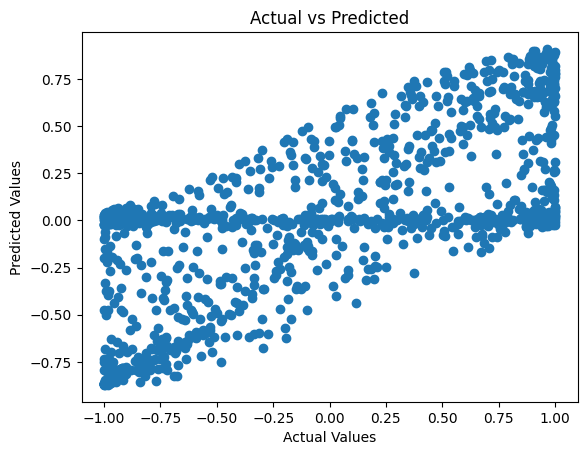

In [186]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

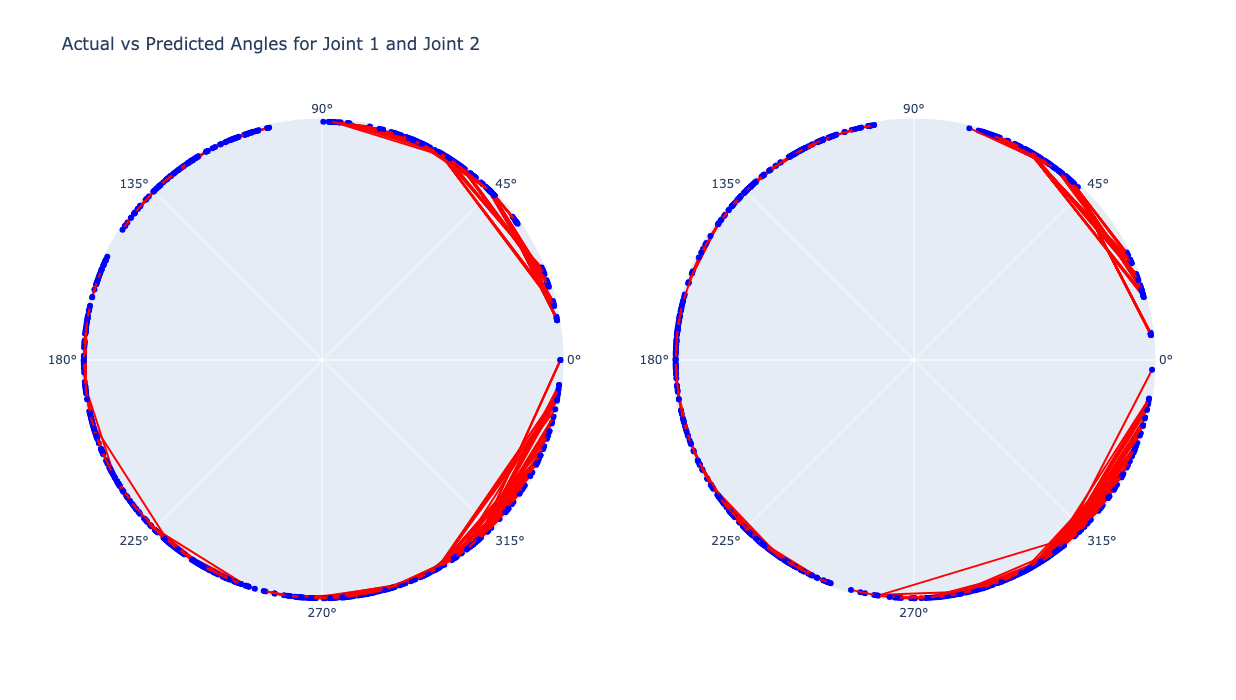

In [373]:
# Function to decode sin and cos back to angles
def decode_angles_from_sin_cos(arr):
    decoded_array = []
    
    for subvector in arr:
        # Extract sine and cosine values
        e1a1 = subvector[-4]
        e2a1 = subvector[-3]
        e1a2 = subvector[-2]
        e2a2 = subvector[-1]
        
        # Reconstruct angles in radians
        angle1_rad = np.arctan2(e1a1, e2a1)
        angle2_rad = np.arctan2(e1a2, e2a2)
        
        # Convert back to degrees
        angle1 = np.rad2deg(angle1_rad)
        angle2 = np.rad2deg(angle2_rad)
        
        # Ensure angles are in the range [0, 360]
        if angle1 < 0:
            angle1 += 360
        if angle2 < 0:
            angle2 += 360
        
        # Create the new subvector with decoded angles
        new_subvector = np.concatenate((subvector[:-4], [angle1, angle2]))
        decoded_array.append(new_subvector)
    
    return np.array(decoded_array)

# decode angles
#decoded_test = decode_angles_from_sin_cos(y_test[:1000])
#decoded_pred= decode_angles_from_sin_cos(predictions[:1000])
# direct angles
decoded_test = y_test[:1000]
decoded_pred= predictions[:1000]

actual_angles_1 = decoded_test[:, 0]  # Actual angles for joint 1
actual_angles_2 = decoded_test[:, 1]  # Actual angles for joint 2
predicted_angles_1 = decoded_pred[:, 0]  # Predicted angles for joint 1
predicted_angles_2 = decoded_pred[:, 1]  # Predicted angles for joint 2

# Convert angles to radians for plotting
actual_angles_1_rad = np.radians(actual_angles_1)
actual_angles_2_rad = np.radians(actual_angles_2)
predicted_angles_1_rad = np.radians(predicted_angles_1)
predicted_angles_2_rad = np.radians(predicted_angles_2)

# Create a subplot with two polar plots for joint 1 and joint 2
fig = sp.make_subplots(rows=1, cols=2, specs=[[{'type': 'polar'}, {'type': 'polar'}]], vertical_spacing=0.1)

# Plot Joint 1 (Actual vs Predicted)
for i in range(len(actual_angles_1)):
    fig.add_trace(go.Scatterpolar(
        r=[1, 1],
        theta=[np.degrees(actual_angles_1_rad[i]), np.degrees(predicted_angles_1_rad[i])],
        mode='lines+markers',
        marker=dict(color='blue'),
        line=dict(color='red'),
        name=f'Joint 1 - Point {i+1}'
    ), row=1, col=1)

# Plot Joint 2 (Actual vs Predicted)
for i in range(len(actual_angles_2)):
    fig.add_trace(go.Scatterpolar(
        r=[1, 1],
        theta=[np.degrees(actual_angles_2_rad[i]), np.degrees(predicted_angles_2_rad[i])],
        mode='lines+markers',
        marker=dict(color='blue'),
        line=dict(color='red'),
        name=f'Joint 2 - Point {i+1}'
    ), row=1, col=2)

# Update layout for the polar plots
fig.update_layout(
    title="Actual vs Predicted Angles for Joint 1 and Joint 2",
    showlegend=False,
    height=700,  # Increase the height to make the plots taller
    polar=dict(
        radialaxis=dict(visible=False),
        angularaxis=dict(direction="counterclockwise")
    ),
    polar2=dict(
        radialaxis=dict(visible=False),
        angularaxis=dict(direction="counterclockwise")
    )
)

# Show the plot
fig.show()

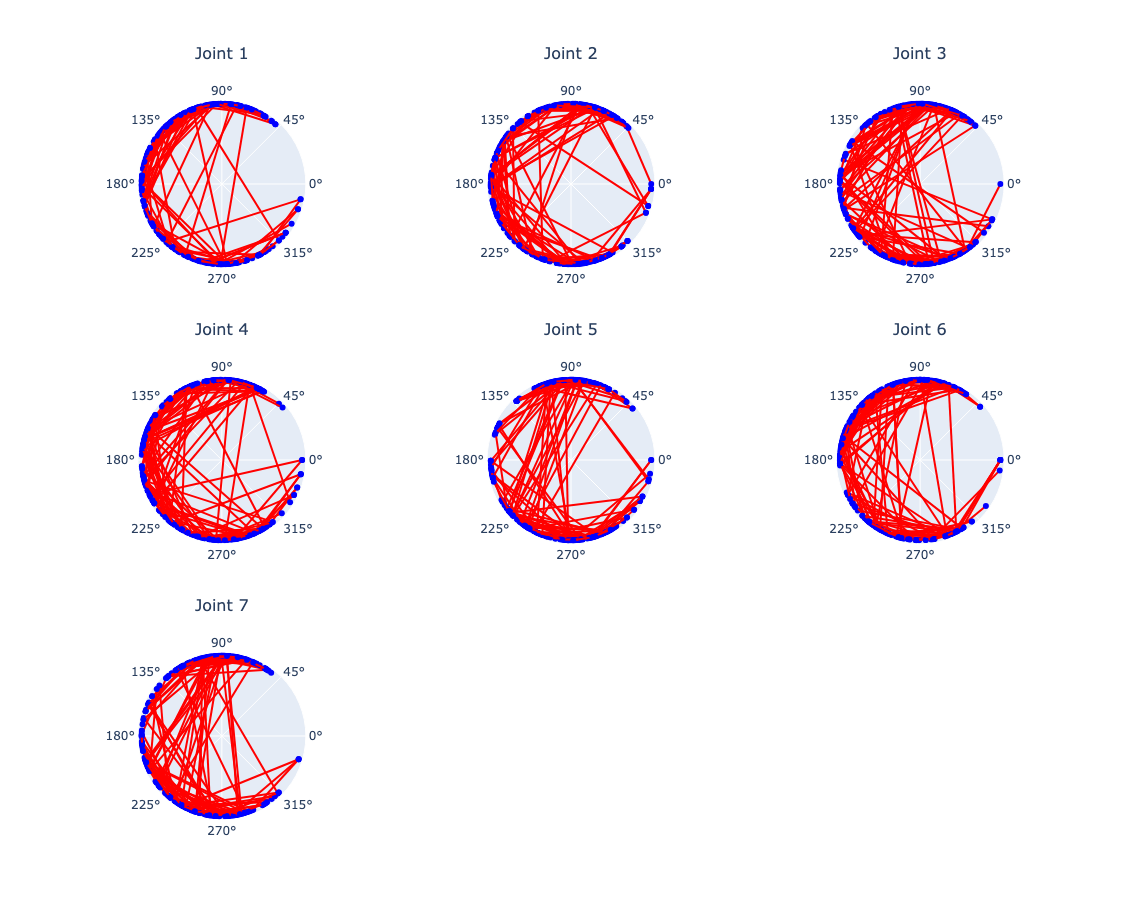

In [478]:
# 7 joint output display
def decode_angles_from_sin_cos(arr):
    decoded_array = []
    
    for subvector in arr:
        angles = []
        for i in range(7):
            e1 = subvector[-14 + 2 * i]
            e2 = subvector[-13 + 2 * i]
            
            # Reconstruct angle in radians
            angle_rad = np.arctan2(e1, e2)
            
            # Convert back to degrees
            angle_deg = np.rad2deg(angle_rad)
            
            # Ensure angle is in the range [0, 360]
            if angle_deg < 0:
                angle_deg += 360
            
            angles.append(angle_deg)
        
        # Create the new subvector with decoded angles
        new_subvector = np.concatenate((subvector[:-14], angles))
        decoded_array.append(new_subvector)
    
    return np.array(decoded_array)

# decode angles
#decoded_test = decode_angles_from_sin_cos(y_test[:1000])
#decoded_pred= decode_angles_from_sin_cos(predictions[:1000])
# direct angles
decoded_test = y_test[:500]
decoded_pred= predictions[:500]

def plot_joint_angles(decoded_test, decoded_pred, joint_names):
    actual_angles = [decoded_test[:, i] for i in range(7)]  # Actual angles for each joint
    predicted_angles = [decoded_pred[:, i] for i in range(7)]  # Predicted angles for each joint

    # Convert angles to radians for plotting
    actual_angles_rad = [np.radians(angles) for angles in actual_angles]
    predicted_angles_rad = [np.radians(angles) for angles in predicted_angles]

    # Create a 3x3 subplot grid for seven joints, with one empty plot
    fig = sp.make_subplots(
        rows=3, cols=3, 
        specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}],
               [{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}],
               [{'type': 'polar'}, {'type': 'polar'}, None]],
        subplot_titles=joint_names,
        vertical_spacing=0.15  # Increase vertical spacing
    )

    positions = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1)]

    for joint in range(7):
        row, col = positions[joint]
        for i in range(len(actual_angles[joint])):
            fig.add_trace(go.Scatterpolar(
                r=[1, 1],
                theta=[np.degrees(actual_angles_rad[joint][i]), np.degrees(predicted_angles_rad[joint][i])],
                mode='lines+markers',
                marker=dict(color='blue'),
                line=dict(color='red'),
                name=f'Joint {joint+1} - Point {i+1}'
            ), row=row, col=col)

    # Update layout for the polar plots and adjust the title positions
    fig.update_layout(
        title="",
        showlegend=False,
        height=900,  # Adjust the height to make the plots fit nicely
    )

    for i in range(7):
        row, col = positions[i]
        fig.update_layout(**{f'polar{i+1}': dict(
            radialaxis=dict(visible=False),
            angularaxis=dict(direction="counterclockwise")
        )})
    
    # Adjust the subplot titles to be higher
    for i, annotation in enumerate(fig['layout']['annotations']):
        annotation['y'] += 0.05  # Move title up by 0.05

    # Show the plot
    fig.show()

# Example joint names
joint_names = ["Joint 1", "Joint 2", "Joint 3", "Joint 4", "Joint 5", "Joint 6", "Joint 7"]

# Example usage for plotting
plot_joint_angles(decoded_test, decoded_pred, joint_names)

In [ ]:
# Create figure
fig = go.Figure()

# Create the new vector by selecting the sampled rows
paired_test = np.hstack([decoded_test, decoded_pred])
# Assume final_paired_result is your existing array of vectors
num_samples = min(100, len(paired_test))  # Ensure we don't exceed the number of available samples
# Randomly pick indices from the final_paired_result
random_indices = np.random.choice(len(paired_test), num_samples, replace=False)
# Create the new vector by selecting the sampled rows
sampled_paired_test = paired_test[random_indices]

# Plot each pair of vectors
for pair in sampled_paired_test:
    # Extract coordinates
    a1, a2, b1, b2 = pair
    
    # Add green dot for (a1, a2)
    fig.add_trace(go.Scatter(x=[a1], y=[a2], mode='markers', marker=dict(color='green'), name='A'))
    
    # Add black dot for (b1, b2)
    fig.add_trace(go.Scatter(x=[b1], y=[b2], mode='markers', marker=dict(color='black'), name='B'))
    
    # Add red line connecting the pair
    fig.add_trace(go.Scatter(x=[a1, b1], y=[a2, b2], mode='lines', line=dict(color='red', width=1), showlegend=False))

# Update layout for a square plot
fig.update_layout(
    title="Vector Pairing Visualization",
    xaxis_title="X Axis",
    yaxis_title="Y Axis",
    showlegend=False,
    width=700,  # Set the width to 700 pixels
    height=700,  # Set the height to 700 pixels
    xaxis=dict(scaleanchor="y", scaleratio=1),  # Ensure the aspect ratio is 1:1
    yaxis=dict(scaleanchor="x", scaleratio=1),
)

# Show plot
fig.show()

In [293]:
# encode dataset for cyclical models
# Function to encode angles with sin and cos and add two zeros at the end for non-first vectors
def encode_and_pad_vectors(arr):
    encoded_array = []
    
    for i, subvector in enumerate(arr):
        if i == 0:
            # Encode the last two elements (angles) in the first vector
            angle1 = subvector[-2]
            angle2 = subvector[-1]
            
            # Convert angles to radians
            angle1_rad = np.deg2rad(angle1)
            angle2_rad = np.deg2rad(angle2)
            
            # Compute sine and cosine of each angle
            e1a1 = np.sin(angle1_rad)
            e2a1 = np.cos(angle1_rad)
            e1a2 = np.sin(angle2_rad)
            e2a2 = np.cos(angle2_rad)
            
            # Create the new subvector with encoded angles and keep all other elements the same
            new_subvector = np.concatenate((subvector[:-2], [e1a1, e2a1, e1a2, e2a2]))
        else:
            # For other vectors, just add two zeros at the end
            new_subvector = np.concatenate((subvector, [0, 0]))
        
        encoded_array.append(new_subvector)
    
    return np.array(encoded_array)

# testing datasets
raw_line_test = np.load('Datasets/simple_line_test_v1_ssl.npy')
raw_line_test_cyclical = np.array([encode_and_pad_vectors(line) for line in raw_line_test])
print(type(raw_line_test_cyclical), type(raw_line_test_cyclical[0]), len(raw_line_test_cyclical), len(raw_line_test_cyclical[0]))
print(raw_line_test_cyclical[0:1])

raw_line_test2 = raw_line_test #[0:1]

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 10 9
[[[ 0.08024259  0.60754389  0.5         0.05650087  0.87038566
    0.5         0.49348653 -0.86975344 -0.78490334 -0.61961823]
  [ 0.1039843   0.34470213  0.5         0.          0.
    0.          0.          0.          0.          0.        ]
  [ 0.12772601  0.08186037  0.5         0.          0.
    0.          0.          0.          0.          0.        ]
  [ 0.15146772 -0.1809814   0.5         0.          0.
    0.          0.          0.          0.          0.        ]
  [ 0.17520943 -0.44382316  0.5         0.          0.
    0.          0.          0.          0.          0.        ]
  [ 0.19895115 -0.70666493  0.5         0.          0.
    0.          0.          0.          0.          0.        ]
  [ 0.22269286 -0.96950669  0.5         0.          0.
    0.          0.          0.          0.          0.        ]
  [ 0.24643457 -1.23234846  0.5         0.          0.
    0.          0.          0.          0.         

In [550]:
# testing datasets | BAD lines for complex: 2, 4, 7, 9
raw_line_test = np.load('Datasets/complex_line_test_ssl.npy')
print(type(raw_line_test), type(raw_line_test[0]), len(raw_line_test), len(raw_line_test[0]))
print(raw_line_test[0:1])

X_line_test = raw_line_test[:, :8]
y_line_test = raw_line_test[:, 8:]

raw_line_test2 = raw_line_test #[5:6]

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 10 9
[[[  3.13574674  -1.86546342   3.23117166   3.25658145  -2.60475658
     3.16792039  -4.28070532   0.65373444   0.34740621  40.8805
   171.3175     302.1895     134.2355    ]
  [  3.01491202  -1.12617025   3.29442293   0.           0.
     0.           0.           0.           0.           0.
     0.           0.           0.        ]
  [  2.8940773   -0.38687709   3.35767421   0.           0.
     0.           0.           0.           0.           0.
     0.           0.           0.        ]
  [  2.77324258   0.35241608   3.42092548   0.           0.
     0.           0.           0.           0.           0.
     0.           0.           0.        ]
  [  2.65240787   1.09170924   3.48417676   0.           0.
     0.           0.           0.           0.           0.
     0.           0.           0.        ]
  [  2.53157315   1.8310024    3.54742803   0.           0.
     0.           0.           0.           0.           0.


In [610]:
raw_line_test2

array([[[ 3.70467451e-02, -9.52266660e-01,  5.00000000e-01,
          2.57536432e-02, -1.22516599e+00,  5.00000000e-01,
          3.23417895e+02,  2.55572632e+02],
        [ 4.83398470e-02, -6.79367328e-01,  5.00000000e-01,
         -1.90167968e-01, -1.00970865e+00,  5.00000000e-01,
          3.18421265e+02,  2.41825256e+02],
        [ 5.96329489e-02, -4.06467995e-01,  5.00000000e-01,
         -2.25292180e-01, -6.21550256e-01,  5.00000000e-01,
          3.20773224e+02,  2.18605621e+02],
        [ 7.09260508e-02, -1.33568663e-01,  5.00000000e-01,
         -1.57825911e-01, -3.07575665e-01,  5.00000000e-01,
          3.22882629e+02,  1.99907410e+02],
        [ 8.22191527e-02,  1.39330669e-01,  5.00000000e-01,
         -4.12471299e-02, -6.10810670e-02,  5.00000000e-01,
          3.23857483e+02,  1.84223862e+02],
        [ 9.35122546e-02,  4.12230001e-01,  5.00000000e-01,
          7.29368338e-02,  9.00773391e-02,  5.00000000e-01,
          3.24324707e+02,  1.73355469e+02],
        [ 1.0480

In [552]:
def predict_and_update(raw_line_test, loaded_model, recurrent_steps=1):
    # Initialize the output array with the same shape as the input
    n_series, n_vectors, _ = raw_line_test.shape
    output = np.zeros_like(raw_line_test)
    
    # Iterate through each line in the 3D vector of lines
    for series_index, line in enumerate(raw_line_test):
        for i in range(len(line)):
            # Extract desired and current configurations
            xp, yp, zp = line[i][:3]  # Desired XYZ
            xc, yc, zc = line[i][3:6]  # Current XYZ
            a1c, a2c = line[i][6:8]    # Current joint angles

            best_config = None
            min_distance = float('inf')

            # Prepare the input vector for prediction
            X_input = np.array([xp, yp, zp, xc, yc, zc, a1c, a2c]).reshape(1, -1)

            # Predict the configuration for the desired XYZ
            predicted_angles = loaded_model.predict(X_input).flatten()
            resulting_xyz = SimpleRobotEndEffector(predicted_angles, 1.0)
            distance = np.linalg.norm(resulting_xyz - np.array([xp, yp, zp]))

            if distance < min_distance:
                min_distance = distance
                best_config = np.concatenate(([xp, yp, zp], resulting_xyz, predicted_angles))

            # Recurrent predictions
            if recurrent_steps > 1:
                for step in range(recurrent_steps - 1):
                    xr, yr, zr = resulting_xyz
                    a1r, a2r = predicted_angles

                    X_input_recurrent = np.array([xp, yp, zp, xr, yr, zr, a1r, a2r]).reshape(1, -1)
                    predicted_angles = loaded_model.predict(X_input_recurrent).flatten()
                    resulting_xyz = SimpleRobotEndEffector(predicted_angles, 1.0)

                    distance = np.linalg.norm(resulting_xyz - np.array([xp, yp, zp]))

                    if distance < min_distance:
                        min_distance = distance
                        best_config = np.concatenate(([xp, yp, zp], resulting_xyz, predicted_angles))

            # Store the best configuration for this vector
            output[series_index, i, :] = best_config

            # Update the next line vector with the best-predicted configuration
            if i < len(line) - 1:
                if np.all(line[i + 1][3:6] == 0) and np.all(line[i + 1][6:8] == 0):
                    line[i + 1][3:6] = best_config[3:6]  # Update current XYZ
                    line[i + 1][6:8] = best_config[6:8]  # Update current joint angles

    return output

In [530]:
def predict_and_update(raw_line_test, loaded_model, recurrent_steps=1, max_no_improvement_steps=2):
    # Initialize the output array with the same shape as the input
    n_series, n_vectors, _ = raw_line_test.shape
    output = np.zeros_like(raw_line_test)
    
    # Iterate through each line in the 3D vector of lines
    for series_index, line in enumerate(raw_line_test):
        print(f"Series {series_index + 1}/{n_series}")
        for i in range(len(line)):
            # Extract desired and current configurations
            xp, yp, zp = line[i][:3]  # Desired XYZ
            xc, yc, zc = line[i][3:6]  # Current XYZ
            a1c, a2c = line[i][6:8]    # Current joint angles

            best_config = None
            min_distance = float('inf')

            # Prepare the input vector for prediction
            X_input = np.array([xp, yp, zp, xc, yc, zc, a1c, a2c]).reshape(1, -1)

            # Predict the configuration for the desired XYZ
            predicted_angles = loaded_model.predict(X_input).flatten()
            resulting_xyz = SimpleRobotEndEffector(predicted_angles, 1.0)
            distance = np.linalg.norm(resulting_xyz - np.array([xp, yp, zp]))

            #print(f"Initial Prediction for Vector {i + 1}/{len(line)}:")
            #print(f"  Predicted Angles: {predicted_angles}")
            #print(f"  Resulting XYZ: {resulting_xyz}")
            #print(f"  Distance to Target: {distance}")

            if distance < min_distance:
                min_distance = distance
                best_config = np.concatenate(([xp, yp, zp], resulting_xyz, predicted_angles))

            # Recurrent predictions with possible noise injection
            improvement_found = False
            for _ in range(3):  # Attempt with original, then with noisy target
                if improvement_found:
                    break
                
                no_improvement_steps = 0  # Track number of steps without improvement
                for step in range(recurrent_steps - 1):
                    xr, yr, zr = resulting_xyz
                    a1r, a2r = predicted_angles

                    X_input_recurrent = np.array([xp, yp, zp, xr, yr, zr, a1r, a2r]).reshape(1, -1)
                    predicted_angles = loaded_model.predict(X_input_recurrent).flatten()
                    resulting_xyz = SimpleRobotEndEffector(predicted_angles, 1.0)

                    distance = np.linalg.norm(resulting_xyz - np.array([xp, yp, zp]))

                    #print(f"  Recurrent Step {step + 1}/{recurrent_steps - 1}:")
                    #print(f"    Predicted Angles: {predicted_angles}")
                    #print(f"    Resulting XYZ: {resulting_xyz}")
                    #print(f"    Distance to Target: {distance}")

                    if distance < min_distance:
                        min_distance = distance
                        best_config = np.concatenate(([xp, yp, zp], resulting_xyz, predicted_angles))
                        no_improvement_steps = 0  # Reset if improvement found
                        improvement_found = True  # Mark that an improvement has been found
                    else:
                        no_improvement_steps += 1

                    # Early Stopping: If no improvement after max_no_improvement_steps, break the loop
                    if no_improvement_steps >= max_no_improvement_steps:
                        break

                # If no improvement, perturb the desired XYZ slightly and retry
                if not improvement_found:
                    xp += np.random.uniform(-0.02 * xp, 0.02 * xp)
                    yp += np.random.uniform(-0.02 * yp, 0.02 * yp)
                    # zp += np.random.uniform(-0.005 * zp, 0.005 * zp)
                    #print(f"No improvement found, perturbing desired XYZ to: ({xp}, {yp}, {zp})")

            # Print the best solution found after all recurrent steps
            #print(f"  Best Configuration for Vector {i + 1}/{len(line)} after {recurrent_steps} steps:")
            #print(f"    Best Angles: {best_config[6:8]}")
            #print(f"    Best Resulting XYZ: {best_config[3:6]}")
            #print(f"    Best Distance to Target: {min_distance}")
            #print("---------------------------------------------------")

            # Store the best configuration for this vector
            output[series_index, i, :] = best_config

            # Update the next line vector with the best-predicted configuration
            if i < len(line) - 1:
                next_xyz = line[i + 1][3:6]
                current_distance = np.linalg.norm(next_xyz - np.array([xp, yp, zp]))

                if distance < current_distance or (np.all(next_xyz == 0) and np.all(line[i + 1][6:8] == 0)):
                    line[i + 1][3:6] = best_config[3:6]  # Update current XYZ
                    line[i + 1][6:8] = best_config[6:8]  # Update current joint angles

    return output

In [539]:
def predict_and_update_complex(raw_line_test, loaded_model, recurrent_steps=1, max_no_improvement_steps=2):
    # Initialize the output array with the same shape as the input
    n_series, n_vectors, _ = raw_line_test.shape
    output = np.zeros_like(raw_line_test)
    
    # Iterate through each line in the 3D vector of lines
    for series_index, line in enumerate(raw_line_test):
        print(f"Series {series_index + 1}/{n_series}")
        for i in range(len(line)):
            # Extract desired and current configurations
            xp, yp, zp = line[i][:3]  # Desired XYZ
            xc, yc, zc = line[i][3:6]  # Current XYZ
            a1c, a2c, a3c, a4c, a5c, a6c, a7c = line[i][6:13]    # Current joint angles

            best_config = None
            min_distance = float('inf')

            # Prepare the input vector for prediction
            X_input = np.array([xp, yp, zp, xc, yc, zc, a1c, a2c, a3c, a4c, a5c, a6c, a7c]).reshape(1, -1)

            # Predict the configuration for the desired XYZ
            predicted_angles = loaded_model.predict(X_input).flatten()
            resulting_xyz = RobotEndEffector(predicted_angles, 1.0, 0.25)
            distance = np.linalg.norm(resulting_xyz - np.array([xp, yp, zp]))

            #print(f"Initial Prediction for Vector {i + 1}/{len(line)}:")
            #print(f"  Predicted Angles: {predicted_angles}")
            #print(f"  Resulting XYZ: {resulting_xyz}")
            #print(f"  Distance to Target: {distance}")

            if distance < min_distance:
                min_distance = distance
                best_config = np.concatenate(([xp, yp, zp], resulting_xyz, predicted_angles))

            # Recurrent predictions with possible noise injection
            improvement_found = False
            for _ in range(3):  # Attempt with original, then with noisy target
                if improvement_found:
                    break
                
                no_improvement_steps = 0  # Track number of steps without improvement
                for step in range(recurrent_steps - 1):
                    xr, yr, zr = resulting_xyz
                    a1r, a2r, a3r, a4r, a5r, a6r, a7r = predicted_angles

                    X_input_recurrent = np.array([xp, yp, zp, xr, yr, zr, a1r, a2r, a3r, a4r, a5r, a6r, a7r]).reshape(1, -1)
                    predicted_angles = loaded_model.predict(X_input_recurrent).flatten()
                    resulting_xyz = RobotEndEffector(predicted_angles, 1.0, 0.25)

                    distance = np.linalg.norm(resulting_xyz - np.array([xp, yp, zp]))

                    #print(f"  Recurrent Step {step + 1}/{recurrent_steps - 1}:")
                    #print(f"    Predicted Angles: {predicted_angles}")
                    #print(f"    Resulting XYZ: {resulting_xyz}")
                    #print(f"    Distance to Target: {distance}")

                    if distance < min_distance:
                        min_distance = distance
                        best_config = np.concatenate(([xp, yp, zp], resulting_xyz, predicted_angles))
                        no_improvement_steps = 0  # Reset if improvement found
                        improvement_found = True  # Mark that an improvement has been found
                    else:
                        no_improvement_steps += 1

                    # Early Stopping: If no improvement after max_no_improvement_steps, break the loop
                    if no_improvement_steps >= max_no_improvement_steps:
                        break

                # If no improvement, perturb the desired XYZ slightly and retry
                if not improvement_found:
                    xp += np.random.uniform(-0.02 * xp, 0.02 * xp)
                    yp += np.random.uniform(-0.02 * yp, 0.02 * yp)
                    # zp += np.random.uniform(-0.005 * zp, 0.005 * zp)
                    #print(f"No improvement found, perturbing desired XYZ to: ({xp}, {yp}, {zp})")

            # Print the best solution found after all recurrent steps
            #print(f"  Best Configuration for Vector {i + 1}/{len(line)} after {recurrent_steps} steps:")
            #print(f"    Best Angles: {best_config[6:13]}")
            #print(f"    Best Resulting XYZ: {best_config[3:6]}")
            #print(f"    Best Distance to Target: {min_distance}")
            #print("---------------------------------------------------")

            # Store the best configuration for this vector
            output[series_index, i, :] = best_config

            # Update the next line vector with the best-predicted configuration
            if i < len(line) - 1:
                next_xyz = line[i + 1][3:6]
                current_distance = np.linalg.norm(next_xyz - np.array([xp, yp, zp]))

                if distance < current_distance or (np.all(next_xyz == 0) and np.all(line[i + 1][6:13] == 0)):
                    line[i + 1][3:6] = best_config[3:6]  # Update current XYZ
                    line[i + 1][6:13] = best_config[6:13]  # Update current joint angles

    return output

In [297]:
# Function to decode sin and cos back to angles from a 1D vector
def decode_angles_from_sin_cos_1d(vector):
    # Extract sine and cosine values
    e1a1 = vector[-4]
    e2a1 = vector[-3]
    e1a2 = vector[-2]
    e2a2 = vector[-1]
    
    # Reconstruct angles in radians
    angle1_rad = np.arctan2(e1a1, e2a1)
    angle2_rad = np.arctan2(e1a2, e2a2)
    
    # Convert back to degrees
    angle1 = np.rad2deg(angle1_rad)
    angle2 = np.rad2deg(angle2_rad)
    
    # Ensure angles are in the range [0, 360]
    if angle1 < 0:
        angle1 += 360
    if angle2 < 0:
        angle2 += 360
    
    # Create the new vector with decoded angles
    decoded_vector = np.concatenate((vector[:-4], [angle1, angle2]))
    
    return decoded_vector

def predict_and_update_cyclical(raw_line_test, loaded_model, recurrent_steps=1, max_no_improvement_steps=2):
    # Initialize the output array with the same shape as the input
    n_series, n_vectors, _ = raw_line_test.shape
    output = np.zeros_like(raw_line_test)
    
    # Iterate through each line in the 3D vector of lines
    for series_index, line in enumerate(raw_line_test):
        print(f"Series {series_index + 1}/{n_series}")
        for i in range(len(line)):
            # Extract desired and current configurations
            xp, yp, zp = line[i][:3]  # Desired XYZ
            xc, yc, zc = line[i][3:6]  # Current XYZ
            a1c, a2c, b1c, b2c = line[i][6:10]    # Current joint angles

            best_config = None
            min_distance = float('inf')

            # Prepare the input vector for prediction
            X_input = np.array([xp, yp, zp, xc, yc, zc, a1c, a2c, b1c, b2c]).reshape(1, -1)

            # Predict the configuration for the desired XYZ
            predicted_angles = loaded_model.predict(X_input).flatten()

            predicted_angles_decoded = decode_angles_from_sin_cos_1d(predicted_angles)
            
            resulting_xyz = SimpleRobotEndEffector(predicted_angles_decoded, 1.0)
            distance = np.linalg.norm(resulting_xyz - np.array([xp, yp, zp]))

            print(f"Initial Prediction for Vector {i + 1}/{len(line)}:")
            print(f"  Predicted Angles: {predicted_angles_decoded}")
            print(f"  Resulting XYZ: {resulting_xyz}")
            print(f"  Distance to Target: {distance}")

            if distance < min_distance:
                min_distance = distance
                best_config = np.concatenate(([xp, yp, zp], resulting_xyz, predicted_angles))

            # Recurrent predictions
            improvement_found = False
            for _ in range(3):  # Attempt with original, then with noisy target
                if improvement_found:
                    break
                
                no_improvement_steps = 0  # Track number of steps without improvement
                for step in range(recurrent_steps - 1):
                    xr, yr, zr = resulting_xyz
                    a1r, a2r, b1r, b2r = predicted_angles

                    X_input_recurrent = np.array([xp, yp, zp, xr, yr, zr, a1r, a2r, b1r, b2r]).reshape(1, -1)
                    predicted_angles = loaded_model.predict(X_input_recurrent).flatten()

                    predicted_angles_decoded = decode_angles_from_sin_cos_1d(predicted_angles)
                    
                    resulting_xyz = SimpleRobotEndEffector(predicted_angles_decoded, 1.0)

                    distance = np.linalg.norm(resulting_xyz - np.array([xp, yp, zp]))

                    print(f"  Recurrent Step {step + 1}/{recurrent_steps - 1}:")
                    print(f"    Predicted Angles: {predicted_angles_decoded}")
                    print(f"    Resulting XYZ: {resulting_xyz}")
                    print(f"    Distance to Target: {distance}")

                    if distance < min_distance:
                        min_distance = distance
                        best_config = np.concatenate(([xp, yp, zp], resulting_xyz, predicted_angles))
                        no_improvement_steps = 0  # Reset if improvement found
                        improvement_found = True  # Mark that an improvement has been found
                    else:
                        no_improvement_steps += 1

                    # Early Stopping: If no improvement after max_no_improvement_steps, break the loop
                    if no_improvement_steps >= max_no_improvement_steps:
                        break

                # If no improvement, perturb the desired XYZ slightly and retry
                if not improvement_found:
                    xp += np.random.uniform(-0.02 * xp, 0.02 * xp)
                    yp += np.random.uniform(-0.02 * yp, 0.02 * yp)
                    # zp += np.random.uniform(-0.005 * zp, 0.005 * zp)
                    print(f"No improvement found, perturbing desired XYZ to: ({xp}, {yp}, {zp})")

            # Print the best solution found after all recurrent steps
            print(f"  Best Configuration for Vector {i + 1}/{len(line)} after {recurrent_steps} steps:")
            print(f"    Best Angles: {best_config[6:10]}")
            print(f"    Best Resulting XYZ: {best_config[3:6]}")
            print(f"    Best Distance to Target: {min_distance}")
            print("---------------------------------------------------")

            # Store the best configuration for this vector
            output[series_index, i, :] = best_config

            # Update the next line vector with the best-predicted configuration
            if i < len(line) - 1:
                next_xyz = line[i + 1][3:6]
                current_distance = np.linalg.norm(next_xyz - np.array([xp, yp, zp]))

                if distance < current_distance or (np.all(next_xyz == 0) and np.all(line[i + 1][6:10] == 0)):
                    line[i + 1][3:6] = best_config[3:6]  # Update current XYZ
                    line[i + 1][6:10] = best_config[6:10]  # Update current joint angles

    return output

In [532]:
line_test_result = predict_and_update(raw_line_test=raw_line_test2,
                                      loaded_model=loaded_model,
                                      recurrent_steps=10, # 10
                                      max_no_improvement_steps=5) # 5

Series 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [551]:
line_test_result = predict_and_update_complex(raw_line_test=raw_line_test2,
                                              loaded_model=loaded_model,
                                              recurrent_steps=10, # 10
                                              max_no_improvement_steps=5) # 5

Series 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [301]:
# np.save('Datasets/line_test_result_1.npy', line_test_result)

In [557]:
fig = go.Figure()
line_ = 10 # BAD lines for complex: 2, 4, 7, 9
# Iterate over each line and plot it with different colors for desired and current positions
for i, line_points in enumerate(line_test_result[line_-1:line_]):
    # Extract desired (xp, yp, zp) and current (xc, yc, zc) positions
    xp_positions = line_points[:, 0]  # Xp Position
    yp_positions = line_points[:, 1]  # Yp Position
    zp_positions = line_points[:, 2]  # Zp Position
    
    xc_positions = line_points[:, 3]  # Xc Position
    yc_positions = line_points[:, 4]  # Yc Position
    zc_positions = line_points[:, 5]  # Zc Position

    print(line_points[:, :6])
    
    # Calculate Mean Absolute Error
    mae = mean_absolute_error(line_points[:, :3], line_points[:, 3:6])
    print(f"Mean Absolute Error: {mae:.4f}")
    
    # Assuming y_tests and predictions_list are lists of arrays from multiple runs
    mae_list = []
    
    # Loop through multiple runs (or cross-validation folds)
    for y_t, prediction in zip(line_points[:, :3], line_points[:, 3:6]):
        mae = mean_absolute_error(y_t, prediction)
        mae_list.append(mae)
    
    # Calculate the standard deviation of the MAE
    std_dev_mae = np.std(mae_list)
    print(f"Standard Deviation of MAE: {std_dev_mae:.4f}")

    # Calculate R-squared
    r2 = r2_score(line_points[:, :3], line_points[:, 3:6])
    print(f"R-squared: {r2:.4f}")
    
    # Plot desired positions (xp, yp, zp) with one color
    fig.add_trace(go.Scatter3d(
        x=xp_positions,
        y=yp_positions,
        z=zp_positions,
        mode='markers',
        marker=dict(
            size=3,
            color=px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)],  # Use different color for each line
        ),
        name=f'Line {i + 1} Desired'
    ))
    
    # Plot current positions (xc, yc, zc) with another color
    fig.add_trace(go.Scatter3d(
        x=xc_positions,
        y=yc_positions,
        z=zc_positions,
        mode='markers',
        marker=dict(
            size=3,
            color=px.colors.qualitative.Set1[i % len(px.colors.qualitative.Set1)],  # Use another set of colors for current points
        ),
        name=f'Line {i + 1} Current'
    ))

# Set plot titles, labels, and ensure the plot is proportional
fig.update_layout(
    title="3D Scatter Plot of Desired (xp, yp, zp) and Current (xc, yc, zc) Points",
    scene=dict(
        xaxis=dict(title="X Position", range=[-7, 7]),
        yaxis=dict(title="Y Position", range=[-7, 7]),
        zaxis=dict(title="Z Position", range=[-2, 8]),
        aspectmode='manual',  # Set the aspect mode to manual
        aspectratio=dict(x=1, y=1, z=1)  # Maintain proportionality: x and y are equal, z is half
    ),
    width=800,  # Increase width
    height=800  # Increase height
)

fig.show()

[[ 4.7496904   0.96733841  3.94982455  4.61259853  0.95041982  3.42843907]
 [ 4.5228136   0.68579632  4.05477022  4.11304324  0.57672794  3.74013671]
 [ 4.35931189  0.39516562  4.15971588  4.04743715  0.47813151  3.85460437]
 [ 4.12871144  0.1071548   4.26466154  3.72218562  0.43430762  4.28660891]
 [ 3.96893338 -0.17700717  4.36960721  3.68836597 -0.12106296  4.35610454]
 [ 3.77374413 -0.46309357  4.47455287  3.61043689 -0.38813623  4.42083561]
 [ 3.57855488 -0.74917996  4.57949854  3.56600409 -0.37299295  4.4662085 ]
 [ 3.38336563 -1.03526636  4.6844442   3.50515449 -0.367435    4.51866594]
 [ 3.18817637 -1.32135276  4.78938987  3.43051389 -0.32495977  4.58432288]]
Mean Absolute Error: 0.2410
Standard Deviation of MAE: 0.1091
R-squared: 0.5127


#### load the model for further training
model = load_model('models/7JointV9', custom_objects={'<lambda>': DistanceLoss})

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer00_relu (Dense)        (None, 177)               1416      
                                                                 
 Output_linear (Dense)       (None, 3)                 534       
                                                                 
Total params: 1950 (7.62 KB)
Trainable params: 1950 (7.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


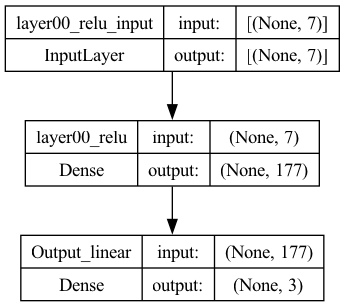

In [38]:
# see the model summary and graph
model.summary()
plot_model(model, to_file='model7JointV9.png', show_shapes=True, show_layer_names=True)

In [44]:
# modify the existing model: freeze parameters
for layer in model.layers:
    layer.trainable = False

In [34]:
# Create a Normalization layer and adapt it to the sample data
normalizer = Normalization(axis=-1)
normalizer.adapt(labels)

In [133]:
# Build complex model
model = Sequential()
model.add(Input(shape=(3,)))
#model.add(normalizer)
model.add(Dense(100, activation='linear', name='layer00_linear'))
model.add(Reshape((10,10,1)))
model.add(Conv2D(50, (7, 7), activation='elu', padding='same', name='CONV01_elu'))
model.add(Conv2D(30, (5, 5), activation='elu', padding='same', name='CONV02_elu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
#model.add(Reshape((54,5)))
#model.add(GRU(7, activation='elu', return_sequences=True, name='GRU03_elu'))
#model.add(GRU(7, activation='elu', return_sequences=False, name='GRU04_elu'))
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu', name='layer04_relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', name='layer05_relu'))
model.add(Dropout(0.15))
model.add(Dense(7, activation='sigmoid', name='layer06_sigmoid'))

model.compile(optimizer='nadam', loss=lambda y_true, y_pred: DistanceLoss(y_true, y_pred))
model.summary()
#plot_model(model, to_file='model_complex_v3.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer00_linear (Dense)      (None, 100)               400       
                                                                 
 reshape_2 (Reshape)         (None, 10, 10, 1)         0         
                                                                 
 CONV01_elu (Conv2D)         (None, 10, 10, 50)        2500      
                                                                 
 CONV02_elu (Conv2D)         (None, 10, 10, 30)        37530     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 30)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 270)               0         
                                                      

In [68]:
# Split the dataset into training and validation sets
X_train_x, X_val_x, y_train_x, y_val_x = train_test_split(labels, features_x, test_size=0.15)
X_train_y, X_val_y, y_train_y, y_val_y = train_test_split(labels, features_y, test_size=0.15)
X_train_z, X_val_z, y_train_z, y_val_z = train_test_split(labels, features_z, test_size=0.15)
print(X_train_x.shape, y_train_x.shape)

(4406, 2) (4406, 1)


Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_304 (Dense)           (None, 7)                 56        
                                                                 
 dense_305 (Dense)           (None, 16)                128       
                                                                 
 reshape_4 (Reshape)         (None, 1, 16)             0         
                                                                 
 gru_10 (GRU)                (None, 1, 16)             1632      
                                                                 
 gru_11 (GRU)                (None, 16)                1632      
                                                                 
 flatten_6 (Flatten)         (None, 16)                0         
                                                                 
 dense_306 (Dense)           (None, 16)              

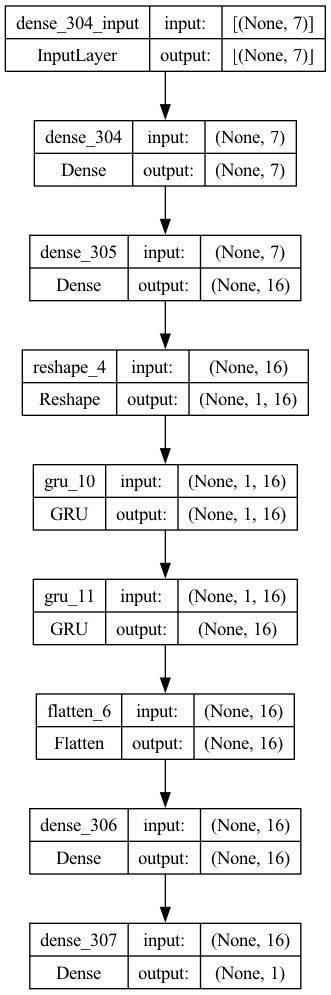

In [223]:
# Build the traditional model
model_x = Sequential([
    Dense(7, activation='sigmoid', input_shape=(7,)),
    Dense(16, activation='tanh'),
    Reshape((1, 16)),
    GRU(16, return_sequences=True),
    GRU(16, return_sequences=False),
    Flatten(),
    Dense(16, activation='tanh'),
    Dense(1, activation='linear')
])
model_y = Sequential([
    Dense(7, activation='sigmoid', input_shape=(7,)),
    Dense(16, activation='tanh'),
    Reshape((1, 16)),
    GRU(16, return_sequences=True),
    GRU(16, return_sequences=False),
    Flatten(),
    Dense(16, activation='tanh'),
    Dense(1, activation='linear')
])
model_z = Sequential([
    Dense(7, activation='sigmoid', input_shape=(7,)),
    Dense(16, activation='tanh'),
    Reshape((1, 16)),
    GRU(16, return_sequences=True),
    GRU(16, return_sequences=False),
    Flatten(),
    Dense(16, activation='tanh'),
    Dense(1, activation='linear')
])

# Compile the model
#model.compile(optimizer='adam', loss='mean_absolute_error') # loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, lb, ls)
model_x.compile(optimizer='nadam', loss='mean_absolute_error')
model_y.compile(optimizer='nadam', loss='mean_absolute_error')
model_z.compile(optimizer='nadam', loss='mean_absolute_error')
model_x.summary()
plot_model(model_x, to_file='model_xV3.png', show_shapes=True, show_layer_names=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 2)                 6         
                                                                 
 dense_21 (Dense)            (None, 16)                48        
                                                                 
 dense_22 (Dense)            (None, 16)                272       
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 343 (1.34 KB)
Trainable params: 343 (1.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


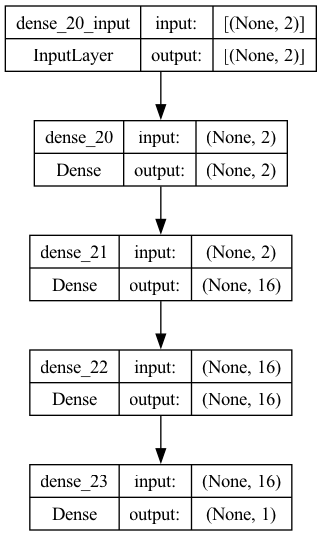

In [69]:
# Build the simple 3 network model
model_x = Sequential([
    Dense(2, activation='sigmoid', input_shape=(2,)),
    Dense(16, activation='relu'),
    Dense(16, activation='tanh'),
    Dense(1, activation='linear')
])
model_y = Sequential([
    Dense(2, activation='sigmoid', input_shape=(2,)),
    Dense(16, activation='relu'),
    Dense(16, activation='tanh'),
    Dense(1, activation='linear')
])
model_z = Sequential([
    Dense(2, activation='sigmoid', input_shape=(2,)),
    Dense(16, activation='relu'),
    Dense(16, activation='tanh'),
    Dense(1, activation='linear')
])
model_x.compile(optimizer='nadam', loss='mean_absolute_error')
model_y.compile(optimizer='nadam', loss='mean_absolute_error')
model_z.compile(optimizer='nadam', loss='mean_absolute_error')
model_x.summary()
plot_model(model_x, to_file='model_simple_3N.png', show_shapes=True, show_layer_names=True)

In [93]:
# Build the simple model
model = Sequential([
    Dense(50, activation='linear', input_shape=(8,), name='layer00_linear'),
    Dense(100, activation='selu', name='layer01_selu'),
    Dense(200, activation='relu', name='layer02_relu'),
    Dense(10, activation='relu', name='layer03_relu'),
    #Dense(10, activation='relu', name='layer04_selu'),
    Dense(2, activation='sigmoid', name='Output_sigmoid')
])
model.compile(optimizer='nadam', loss='mse')
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer00_linear (Dense)       (None, 50)                450       
_________________________________________________________________
layer01_selu (Dense)         (None, 100)               5100      
_________________________________________________________________
layer02_relu (Dense)         (None, 200)               20200     
_________________________________________________________________
layer03_relu (Dense)         (None, 10)                2010      
_________________________________________________________________
Output_sigmoid (Dense)       (None, 2)                 22        
Total params: 27,782
Trainable params: 27,782
Non-trainable params: 0
_________________________________________________________________


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 7)]                  0         []                            
                                                                                                  
 layer01_relu (Dense)        (None, 50)                   400       ['input_13[0][0]']            
                                                                                                  
 layer02_sigmoid (Dense)     (None, 50)                   400       ['input_13[0][0]']            
                                                                                                  
 layer03_linear (Dense)      (None, 50)                   400       ['input_13[0][0]']            
                                                                                           

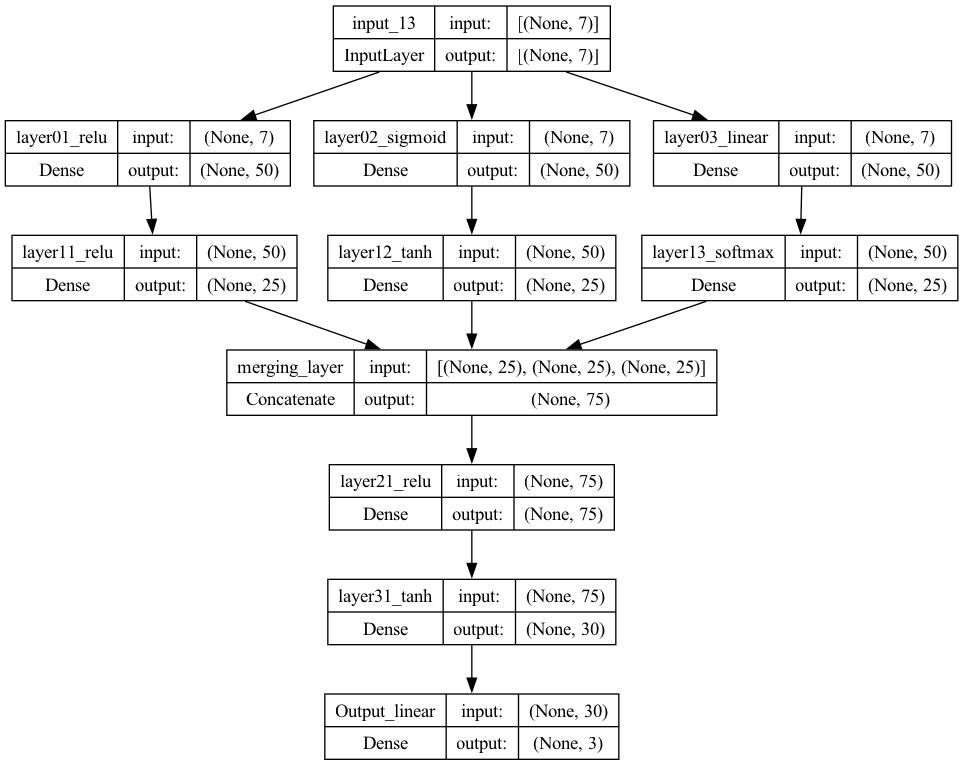

In [126]:
# Build the parallel model
input_layer = Input(shape=(7,))
layer01 = Dense(50, activation='relu', name='layer01_relu')(input_layer)
layer02 = Dense(50, activation='sigmoid', name='layer02_sigmoid')(input_layer)
layer03 = Dense(50, activation='linear', name='layer03_linear')(input_layer)
layer11 = Dense(25, activation='relu', name='layer11_relu')(layer01)
layer12 = Dense(25, activation='tanh', name='layer12_tanh')(layer02)
layer13 = Dense(25, activation='softmax', name='layer13_softmax')(layer03)
combined = Concatenate(name='merging_layer')([layer11, layer12, layer13])
layer21 = Dense(75, activation='relu', name='layer21_relu')(combined)
layer31 = Dense(30, activation='tanh', name='layer31_tanh')(layer21)
output_layer = Dense(3, activation='linear', name='Output_linear')(layer31)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='nadam', loss=lambda y_true, y_pred: DistanceLoss(y_true, y_pred))
model.summary()
plot_model(model, to_file='model_pv2.png', show_shapes=True, show_layer_names=True)

In [118]:
input_layer = Input(shape=(7,7,1))
cl1 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(input_layer)
flatten = Flatten()(cl1)
#shared_layer0 = Dense(10, activation='relu')(input_layer)
#xl = Dense(30, activation='relu')(shared_layer0)
#yl = Dense(30, activation='relu')(shared_layer0)
#zl = Dense(30, activation='relu')(shared_layer0)
#xyz = Concatenate()([xl, yl, zl])
recombined_layer = Dense(10, activation='tanh')(flatten)
output_layer = Dense(3, activation='linear')(recombined_layer)
model = Model(inputs=input_layer, outputs=output_layer)
#Image('model.png')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 7, 7, 1)]         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 16)          160       
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_97 (Dense)            (None, 10)                4010      
                                                                 
 dense_98 (Dense)            (None, 3)                 33        
                                                                 
Total params: 4203 (16.42 KB)
Trainable params: 4203 (16.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


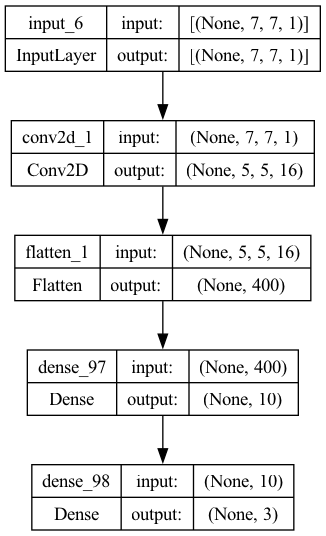

In [159]:
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [70]:
# Train the model
history_x = model_x.fit(X_train_x, y_train_x, epochs=200, batch_size=100, validation_data=(X_val_x, y_val_x))
history_y = model_y.fit(X_train_y, y_train_y, epochs=200, batch_size=100, validation_data=(X_val_y, y_val_y))
history_z = model_z.fit(X_train_z, y_train_z, epochs=200, batch_size=100, validation_data=(X_val_z, y_val_z))

Epoch 1/200
45/45 [==============================] - 0s 2ms/step - loss: 0.8383 - val_loss: 0.7979
Epoch 2/200
45/45 [==============================] - 0s 946us/step - loss: 0.8119 - val_loss: 0.7976
Epoch 3/200
45/45 [==============================] - 0s 840us/step - loss: 0.8114 - val_loss: 0.7983
Epoch 4/200
45/45 [==============================] - 0s 883us/step - loss: 0.8103 - val_loss: 0.7968
Epoch 5/200
45/45 [==============================] - 0s 856us/step - loss: 0.8092 - val_loss: 0.7997
Epoch 6/200
45/45 [==============================] - 0s 860us/step - loss: 0.8083 - val_loss: 0.7931
Epoch 7/200
45/45 [==============================] - 0s 846us/step - loss: 0.8060 - val_loss: 0.7927
Epoch 8/200
45/45 [==============================] - 0s 842us/step - loss: 0.8036 - val_loss: 0.7887
Epoch 9/200
45/45 [==============================] - 0s 839us/step - loss: 0.8004 - val_loss: 0.7846
Epoch 10/200
45/45 [==============================] - 0s 851us/step - loss: 0.7957 - val_loss

In [34]:
model.predict(np.array([[1,1,2]]))

ValueError: in user code:

    File "C:\Users\Marek\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Marek\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Marek\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Marek\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\Marek\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Marek\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 7), found shape=(None, 3)


In [94]:
# Train the simple model
with tf.device('GPU'):
    history = model.fit(X_train, y_train, epochs=10, batch_size=300, validation_data=(X_val, y_val))

Epoch 1/10
534/534 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 4.4898e-04
Epoch 2/10
534/534 [==============================] - 1s 1ms/step - loss: 4.3532e-04 - val_loss: 1.6043e-04
Epoch 3/10
534/534 [==============================] - 1s 1ms/step - loss: 2.4216e-04 - val_loss: 4.5019e-04
Epoch 4/10
534/534 [==============================] - 1s 1ms/step - loss: 1.9849e-04 - val_loss: 1.2814e-04
Epoch 5/10
534/534 [==============================] - 1s 1ms/step - loss: 1.4607e-04 - val_loss: 1.2050e-04
Epoch 6/10
534/534 [==============================] - 1s 1ms/step - loss: 1.2398e-04 - val_loss: 8.2019e-05
Epoch 7/10
534/534 [==============================] - 1s 1ms/step - loss: 9.9352e-05 - val_loss: 1.1605e-04
Epoch 8/10
534/534 [==============================] - 1s 1ms/step - loss: 9.6642e-05 - val_loss: 7.9754e-05
Epoch 9/10
534/534 [==============================] - 1s 1ms/step - loss: 7.9004e-05 - val_loss: 1.0365e-04
Epoch 10/10
534/534 [===========

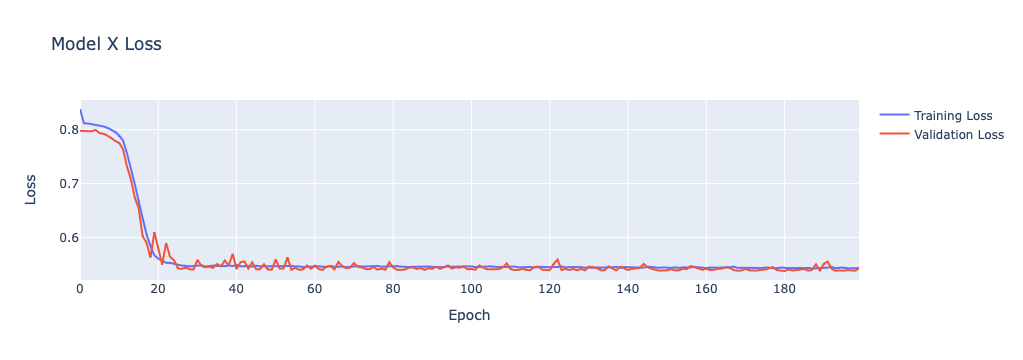

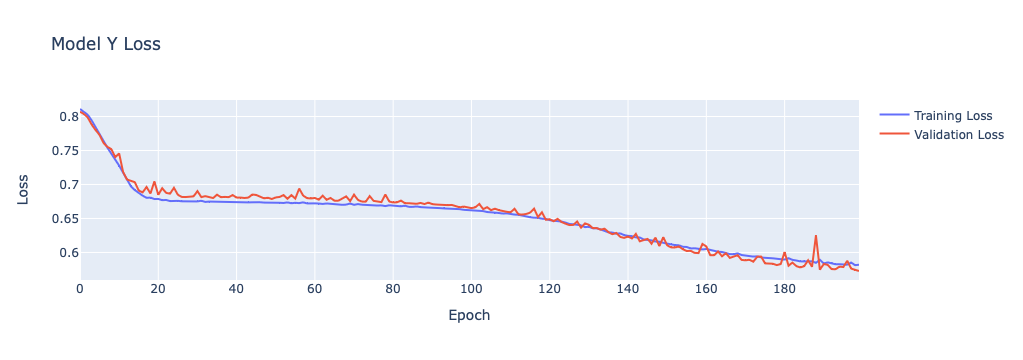

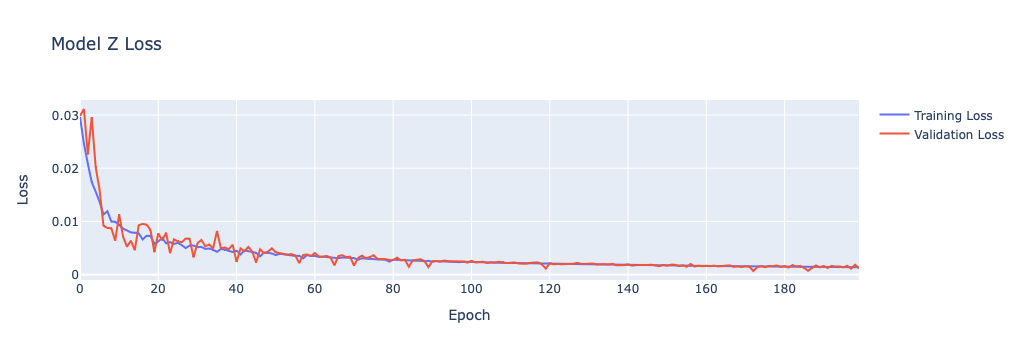

In [72]:
# Create traces for training and validation loss
trace1 = go.Scatter(
    y=history_x.history['loss'],
    mode='lines',
    name='Training Loss'
)
trace2 = go.Scatter(
    y=history_x.history['val_loss'],
    mode='lines',
    name='Validation Loss'
)

data = [trace1, trace2]

# Define the layout of the plot
layout = go.Layout(
    title='Model X Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    hovermode='closest'
)

# Create a figure and plot it
fig = go.Figure(data=data, layout=layout)
iplot(fig)
# Create traces for training and validation loss
trace12 = go.Scatter(
    y=history_y.history['loss'],
    mode='lines',
    name='Training Loss'
)
trace22 = go.Scatter(
    y=history_y.history['val_loss'],
    mode='lines',
    name='Validation Loss'
)

data2 = [trace12, trace22]

# Define the layout of the plot
layout2 = go.Layout(
    title='Model Y Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    hovermode='closest'
)

# Create a figure and plot it
fig2 = go.Figure(data=data2, layout=layout2)
iplot(fig2)
# Create traces for training and validation loss
trace13 = go.Scatter(
    y=history_z.history['loss'],
    mode='lines',
    name='Training Loss'
)
trace23 = go.Scatter(
    y=history_z.history['val_loss'],
    mode='lines',
    name='Validation Loss'
)

data3 = [trace13, trace23]

# Define the layout of the plot
layout3 = go.Layout(
    title='Model Z Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    hovermode='closest'
)

# Create a figure and plot it
fig3 = go.Figure(data=data3, layout=layout3)
iplot(fig3)

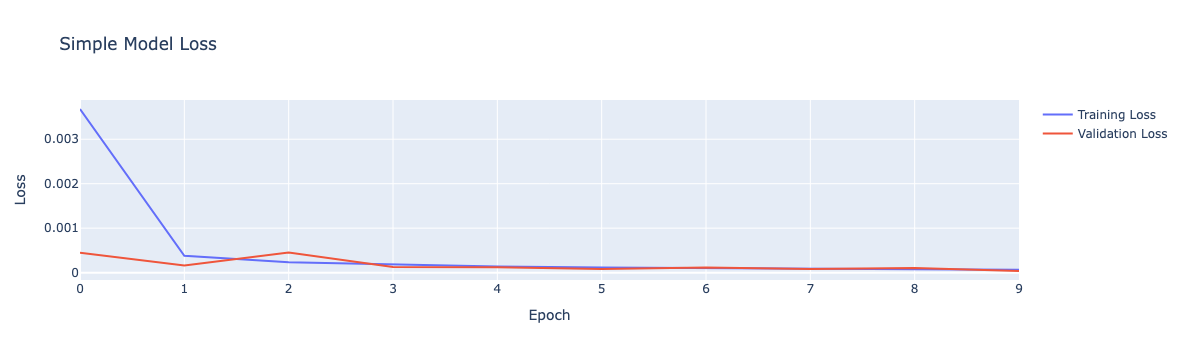

In [95]:
# Create traces for simple model
trace1 = go.Scatter(
    y=history.history['loss'],
    mode='lines',
    name='Training Loss'
)
trace2 = go.Scatter(
    y=history.history['val_loss'],
    mode='lines',
    name='Validation Loss'
)

data = [trace1, trace2]

# Define the layout of the plot
layout = go.Layout(
    title='Simple Model Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    hovermode='closest'
)

# Create a figure and plot it
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [96]:
# new data for prediction (simple robot model)
anglesT = np.random.uniform(0, 360, (2,))
#anglesT2 = np.random.uniform(0, 360, (2,))
#anglesT2 = anglesT*0.1 + anglesT
#anglesT2 = anglesT*np.random.uniform(0,0.15) + anglesT
tmp_v = np.array(SimpleRobotEndEffector(anglesT, 1.0))
mod_v = np.hstack([tmp_v[:2] * 1.02, tmp_v[2:]])
testInputs = np.hstack([tmp_v, anglesT/360,
                        mod_v])
#expectedOutput = anglesT2/360
ti = []
ti.append(testInputs)
ti = np.array(ti)

In [97]:
# rapid testing
predicted = model.predict(ti)
pt = (predicted[0,0]*360, predicted[0,1]*360)
print("initial position:", ti[:, :5])
print("target position: ", ti[:, 5:])
print("predicted position: ", SimpleRobotEndEffector(pt, 1.0))
print("predicted angles:   ", pt)

initial position: [[-0.86248976 -1.40249992  0.5         0.75833185  0.80783573]]
target position:  [[-0.87973956 -1.43054992  0.5       ]]
predicted position:  [-0.8726069258656155, -1.388026635792397, 0.5]
predicted angles:    (272.7824592590332, 290.12261867523193)


In [80]:
# New data for prediction (replace this with your actual new data)
# Example: new_data = np.array([[x1, y1, z1], [x2, y2, z2], ...])
points = generate_random_points()
points = np.vstack(([2.5, 2.5,  2.5], points))
print(points)
new_data = np.array(points)  # Replace with your data
# Make predictions
predicted_angles_normalized = model.predict(new_data)

# Denormalize the predictions to get actual angle values
predicted_angles = predicted_angles_normalized * 360



evaluation = []
for i in range(0, len(points)):
    evaluation.append(RobotGeometry(predicted_angles[i], 1.0, 0.25))

print(evaluation[0][-1])
plot_3d_arm9(evaluation, [6,6,6],3)

[[ 2.5         2.5         2.5       ]
 [-3.80711132  2.70742873  3.85907408]
 [-1.41301795  3.05349728  3.14134876]
 [-1.73031734  1.98225774  4.6978968 ]
 [ 1.14546221 -4.00335492  0.56697412]
 [ 1.81227085  3.76356893  3.87853141]]


ValueError: in user code:

    /home/marek/anaconda3/envs/ML39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/marek/anaconda3/envs/ML39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/marek/anaconda3/envs/ML39/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/marek/anaconda3/envs/ML39/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/marek/anaconda3/envs/ML39/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/marek/anaconda3/envs/ML39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/marek/anaconda3/envs/ML39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/marek/anaconda3/envs/ML39/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/marek/anaconda3/envs/ML39/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected axis -1 of input shape to have value 8 but received input with shape (None, 3)


In [226]:
## New data for prediction (replace this with your actual new data)
# Example: new_data = np.array([[x1, y1, z1], [x2, y2, z2], ...])
angles = []
for i in range(0, 60):
    angles.append(generate_random_vector())#*np.array([1, 0,0,0, 0,0,0]))
angles = np.array(angles)
#print(angles)
#print(angles_image[0])
new_data = np.array(angles)  # Replace with your data
# Make predictions
predicted_x = model_x.predict(new_data)
predicted_y = model_y.predict(new_data)
predicted_z = model_z.predict(new_data)
#print(predicted_x.shape)
predicted_xyz = np.column_stack((predicted_x, predicted_y, predicted_z))

evaluation = []
ev2 = []
for i in range(0, len(angles)):
    evaluation.append(RobotGeometry(angles[i], 1.0, 0.25))
    evaluation[i].append(predicted_xyz[i])
    ev2.append(evaluation[i][-1])

angles = angles/360
ev2 = np.array(ev2)
print(predicted_xyz[0:3])
#test_loss, test_accuracy = model.evaluate(angles, ev2, verbose=1)
plot_3d_arm10(evaluation, predicted_xyz, [16,16,16],21)

2/2 [==============================] - 0s 1ms/step
[[ 2.7401905 -1.2260306  7.4594207]
 [ 3.7197053 -1.2260306  8.233099 ]
 [ 3.7197053 -1.2260306  7.4594207]]


In [59]:
np.random.uniform(0, 90, (2,))*[1, 0]

array([46.86477113,  0.        ])

1/1 [==============================] - 0s 13ms/step


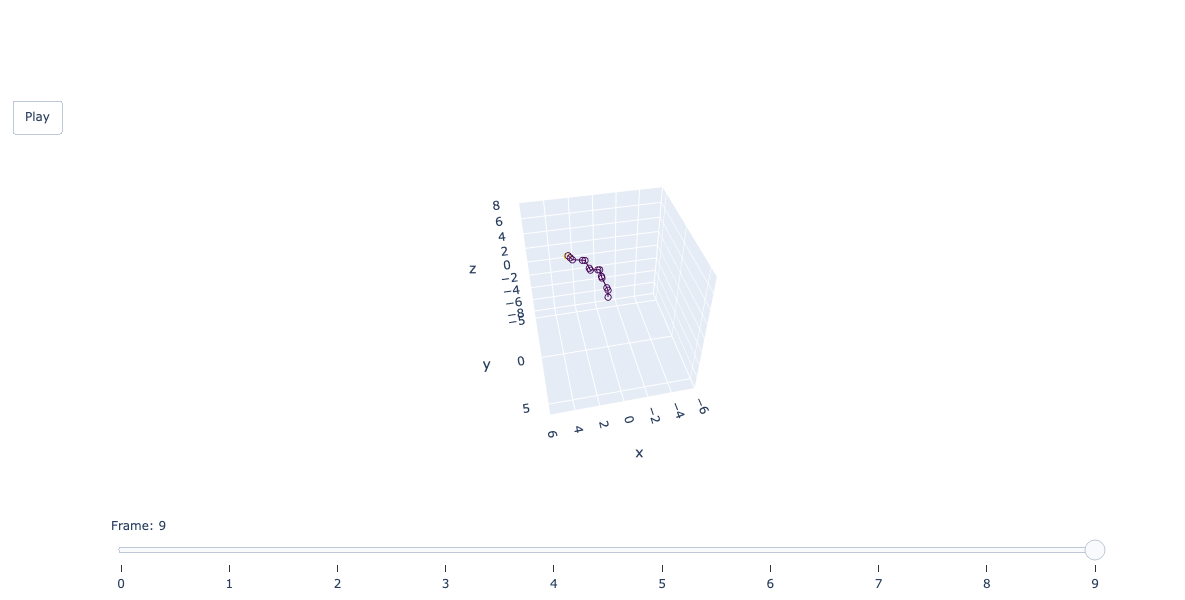

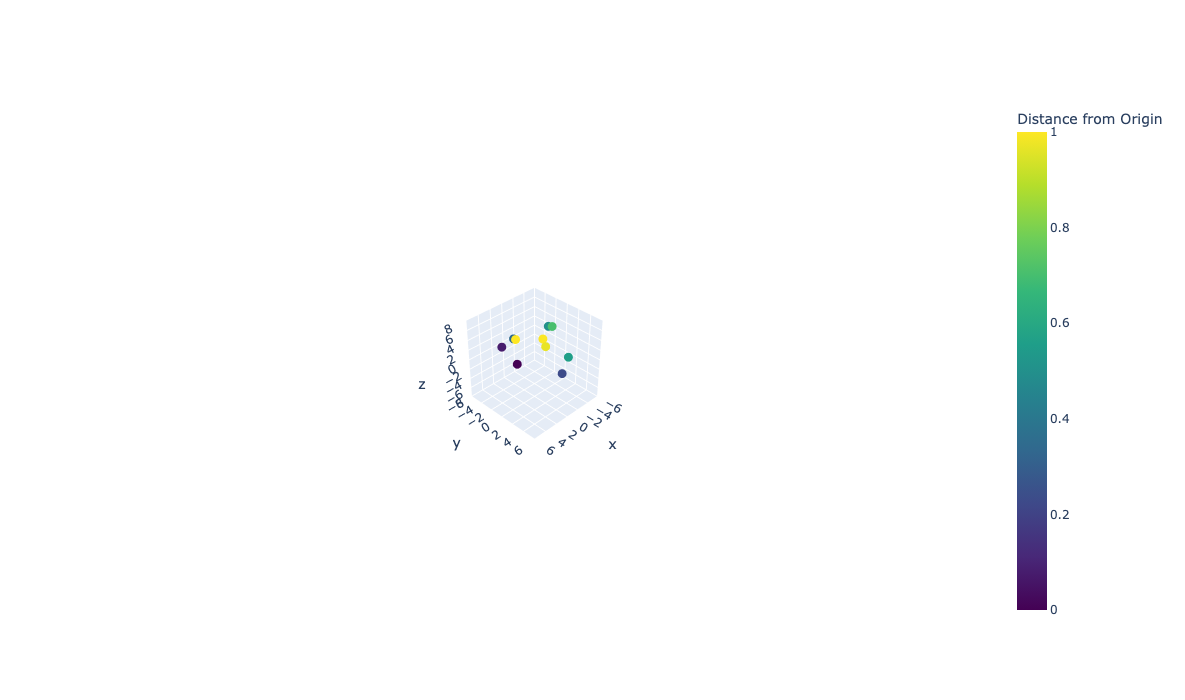

In [124]:
## New data for prediction SIMPLE model
# Example: new_data = np.array([[x1, y1, z1], [x2, y2, z2], ...])
pred_angles = []
disp_angles = []
for i in range(0, 10):
    rnd_ang = np.random.uniform(0, 360, (7,))
    pred_angles.append(rnd_ang/360)#*np.array([1, 0,0,0, 0,0,0]))
    disp_angles.append(rnd_ang)
pred_angles = np.array(pred_angles)
#print(pred_angles)
#print(angles_image[0])
new_data = pred_angles  # Replace with your data
predicted_xyz = model.predict(new_data)
# Make predictions
#predicted_xyz = np.column_stack((predicted_x, predicted_y, predicted_z))

evaluation = []
ev2 = []
for i in range(0, len(disp_angles)):
    evaluation.append(RobotGeometry(disp_angles[i]))
    evaluation[i].append(predicted_xyz[i])
    ev2.append(evaluation[i][-1])

ev2 = np.array(ev2)
#print(predicted_xyz[0:3])
#test_loss, test_accuracy = model.evaluate(angles, ev2, verbose=1)
plot_3d_arm11(evaluation, predicted_xyz, [6,6,8],21)
#print(evaluation[0][-2])
#print(evaluation[0][-1])
plot_3d_points(predicted_xyz, [6,6,8])

In [35]:
model.save('models/SimpleSSL_v5_5DEGx100')

INFO:tensorflow:Assets written to: models/SimpleSSL_v5_5DEGx100\assets


In [98]:
model_loaded = load_model('models/7JointV20CH1', custom_objects={'<lambda>': DistanceLoss})

In [99]:
model_loaded.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer00_relu (Dense)        (None, 400)               3200      
                                                                 
 layer01_relu (Dense)        (None, 300)               120300    
                                                                 
 layer02_relu (Dense)        (None, 200)               60200     
                                                                 
 layer03_tanh (Dense)        (None, 100)               20100     
                                                                 
 Output_linear (Dense)       (None, 3)                 303       
                                                                 
Total params: 204,103
Trainable params: 204,103
Non-trainable params: 0
_________________________________________________________________


In [53]:
data_test = np.load('Dane1M_test.npy')

In [54]:
labels_t = data_test[:, :3]
features_t = data_test[:, 3:]

In [55]:
print(labels_t, len(labels_t), labels_t.shape)
print(features_t, len(features_t), features_t.shape)

[[-3.84548725 -0.39492467 -1.1279758 ]
 [ 0.62772433 -2.27223129  5.53304433]
 [-3.25148524 -0.74759418  5.79183749]
 ...
 [-4.05393137 -1.29930969  3.74150439]
 [-3.18946675 -3.23078448  3.27726079]
 [-0.94471804 -2.04071917  6.39310198]] 5000 (5000, 3)
[[0.97854492 0.58598652 0.0290047  ... 0.21338039 0.71526021 0.27313872]
 [0.50229559 0.25563387 0.57776335 ... 0.91631147 0.89787517 0.50154734]
 [0.15768483 0.19881161 0.78771621 ... 0.27366767 0.20041939 0.26651165]
 ...
 [0.02138544 0.00863908 0.54925515 ... 0.75205698 0.46530196 0.27536487]
 [0.21586632 0.06819367 0.44563999 ... 0.13901494 0.83312497 0.31289298]
 [0.37836729 0.18144673 0.69985352 ... 0.5280352  0.85616404 0.18310798]] 5000 (5000, 7)


In [120]:
y_pred = model_loaded.predict(features_t)

157/157 [==============================] - 0s 763us/step


In [122]:
# add true new random data for evaluation of the model
y_pred = model.predict(features_t)

157/157 [==============================] - 0s 960us/step


In [123]:
# Calculate evaluation metrics
mae = mean_absolute_error(labels_t, y_pred)
mse = mean_squared_error(labels_t, y_pred)
rmse = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(labels_t, y_pred))))
r2 = r2_score(labels_t, y_pred)
n = len(y_pred)  # Number of observations
p = X_val.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print the metrics
print("Mean Absolute Error (MAE): ", mae)
print("Mean Squared Error (MSE): ", mse)
print("Root Mean Squared Error (RMSE): ", rmse)
print("R-squared (R2): ", r2)
print("Adjusted R-squared (R̄²): ", adjusted_r2)

Mean Absolute Error (MAE):  0.08610337284078075
Mean Squared Error (MSE):  0.01250518512949132
Root Mean Squared Error (RMSE):  tf.Tensor(0.11182658507479921, shape=(), dtype=float64)
R-squared (R2):  0.9980615227919817
Adjusted R-squared (R̄²):  0.9980588045747428
